# Лабораторная работа 3

1) Полносвязная нейронная сеть ( Fully-Connected Neural Network)

2) Нормализация по мини-батчам (Batch normalization)

3) Dropout

4) Сверточные нейронные сети (Convolutional Networks)

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

# Полносвязная нейронная сеть

В данной лабораторной работе необходимо будет реализовать полносвязную нейронную сеть, используя модульный подход. Для каждого  слоя реализации прямого и обратного проходов алгоритма обратного распространения ошибки будут иметь следующий вид:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```



```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

    

In [112]:
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits 
from sklearn.model_selection import train_test_split
from math import sqrt, ceil

from gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from solver import Solver
# from scripts.classifiers.cnn import *
from layers import *
from layer_utils import *
# from scripts.fast_layers import *


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))
def print_mean_std(x,axis=0):
    print('  means: ', x.mean(axis=axis))
    print('  stds:  ', x.std(axis=axis))
    print() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Загрузите данные из предыдущей лабораторной работы. 

(64,)


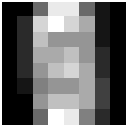

In [113]:
digits = load_digits()

data = {}

x_train, x_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3, shuffle=True, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=True, random_state=42)

data['X_train'] = x_train
data['y_train'] = y_train
data['X_val'] = x_val
data['y_val'] = y_val
data['X_test'] = x_test
data['y_test'] = y_test

mean_image = np.mean(x_train, axis=0)

plt.figure(dpi = 20)
print(mean_image.shape)
plt.imshow(mean_image.reshape(8,8).astype('uint8'))
plt.axis("off")
plt.show()

x_train -= mean_image
x_val -= mean_image
x_test -= mean_image

Для полносвязного слоя реализуйте прямой проход (метод affine_forward в scripts/layers.py). Протестируйте свою реализацию. 

In [114]:
num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


#### Получили адекватную погрешность

Для полносвязного слоя реализуйте обратный проход (метод affine_backward в scripts/layers.py). Протестируйте свою реализацию. 

In [115]:
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


#### Протестировали, получили тоже, что все правильно

Реализуйте прямой проход для слоя активации ReLU (relu_forward) и протестируйте его.

In [116]:
x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


#### Снова все хорошо, протестировали

Реализуйте обратный проход для слоя активации ReLU (relu_backward ) и протестируйте его.

In [117]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


#### И снова все хорошо

В скрипте /layer_utils.py приведены реализации прямого и обратного проходов для часто используемых комбинаций слоев. Например, за полносвязным слоем часто следует слой активации. Ознакомьтесь с функциями affine_relu_forward и affine_relu_backward, запустите код ниже и убедитесь, что ошибка порядка e-10 или ниже. 

In [118]:
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


#### Убедились, ошибка меньше чем e-10

Реализуйте двухслойную полносвязную сеть - класс TwoLayerNet в scripts/classifiers/fc_net.py . Проверьте свою реализацию, запустив код ниже. 

In [119]:
class TwoLayerNet(object):
    """
    A two-layer fully-connected neural network with ReLU nonlinearity and
    softmax loss that uses a modular layer design. We assume an input dimension
    of D, a hidden dimension of H, and perform classification over C classes.

    The architecure should be affine - relu - affine - softmax.

    Note that this class does not implement gradient descent; instead, it
    will interact with a separate Solver object that is responsible for running
    optimization.

    The learnable parameters of the model are stored in the dictionary
    self.params that maps parameter names to numpy arrays.
    """

    def __init__(self, input_dim=3 * 32 * 32, hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,):
        """
        Initialize a new network.

        Inputs:
        - input_dim: An integer giving the size of the input
        - hidden_dim: An integer giving the size of the hidden layer
        - num_classes: An integer giving the number of classes to classify
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - reg: Scalar giving L2 regularization strength.
        """
        self.params = {}
        self.reg = reg

        ############################################################################
        # TODO: Initialize the weights and biases of the two-layer net. Weights    #
        # should be initialized from a Gaussian centered at 0.0 with               #
        # standard deviation equal to weight_scale, and biases should be           #
        # initialized to zero. All weights and biases should be stored in the      #
        # dictionary self.params, with first layer weights                         #
        # and biases using the keys 'W1' and 'b1' and second layer                 #
        # weights and biases using the keys 'W2' and 'b2'.                         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        # Два слоя, запомнили размерности слоев, запомнили их и зарандомили веса
        self.num_layers = 2

        D_H_C_dims = [input_dim] + [hidden_dim] + [num_classes]

        for idx in range(self.num_layers):
            nrows = D_H_C_dims[idx]
            ncols = D_H_C_dims[idx+1]

            layer_name = "%d" % (idx+1)
            weight_name = "W" + layer_name
            bias_name = "b" + layer_name
            self.params[weight_name] = weight_scale * np.random.randn(nrows, ncols)
            self.params[bias_name] = np.zeros(ncols)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

    def loss(self, X, y=None):
        """
        Compute loss and gradient for a minibatch of data.

        Inputs:
        - X: Array of input data of shape (N, d_1, ..., d_k)
        - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

        Returns:
        If y is None, then run a test-time forward pass of the model and return:
        - scores: Array of shape (N, C) giving classification scores, where
          scores[i, c] is the classification score for X[i] and class c.

        If y is not None, then run a training-time forward and backward pass and
        return a tuple of:
        - loss: Scalar value giving the loss
        - grads: Dictionary with the same keys as self.params, mapping parameter
          names to gradients of the loss with respect to those parameters.
        """
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the two-layer net, computing the    #
        # class scores for X and storing them in the scores variable.              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        caches = {}
        scores = X
        # реализуем прямой проход для случая, если слой последний и не последний
        for i in range(1, self.num_layers + 1):
            layer_name = "%d" % i
            W_name = "W" + layer_name
            b_name = "b" + layer_name
            cache_name = "cache" + layer_name

            if self.num_layers == i:
                scores, cache = affine_forward(scores, self.params[W_name],
                                               self.params[b_name])
            else:
                scores, cache = affine_relu_forward(
                scores, self.params[W_name], self.params[b_name])
                
            caches[cache_name] = cache


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If y is None then we are in test mode so just return scores
        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the two-layer net. Store the loss  #
        # in the loss variable and gradients in the grads dictionary. Compute data #
        # loss using softmax, and make sure that grads[k] holds the gradients for  #
        # self.params[k]. Don't forget to add L2 regularization!                   #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # считаем ошибку и градиант при обратном проходе также для двух случаев
        loss, dx = softmax_loss(scores, y)
        
        for i in range(self.num_layers, 0, -1):
            layer_name = "%d" % i
            W_name = "W" + layer_name
            b_name = "b" + layer_name
            cache_name = "cache" + layer_name

            loss += 0.5 * self.reg * (self.params[W_name] ** 2).sum()
            
            if self.num_layers == i:
                dx, grads[W_name], grads[b_name] = affine_backward(dx, caches[cache_name])
                
            else:
                (der, grads[W_name], grads[b_name]) = affine_relu_backward(dx, caches[cache_name])

            grads[W_name] += self.reg * self.params[W_name]
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [120]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.12e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 3.12e-07
W2 relative error: 7.98e-08
b1 relative error: 1.35e-08
b2 relative error: 1.97e-09


Ознакомьтесь с API для обучения и тестирования моделей в scripts/solver.py . Используйте экземпляр класса Solver для обучения двухслойной полносвязной сети. Необходимо достичь минимум 50% верно классифицированных объектов на валидационном наборе. 

In [121]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

model = TwoLayerNet(input_dim=8*8, hidden_dim=100, num_classes=10, weight_scale=1e-2, reg=0.0)

learning_rate = 1e-3
solver = Solver(model, data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1000) loss: 2.302829
(Epoch 0 / 20) train acc: 0.192000; val_acc: 0.133333
(Iteration 11 / 1000) loss: 2.299480
(Iteration 21 / 1000) loss: 2.301976
(Iteration 31 / 1000) loss: 2.300221
(Iteration 41 / 1000) loss: 2.290570
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.277778
(Iteration 51 / 1000) loss: 2.284339
(Iteration 61 / 1000) loss: 2.285525
(Iteration 71 / 1000) loss: 2.273051
(Iteration 81 / 1000) loss: 2.272996
(Iteration 91 / 1000) loss: 2.275884
(Epoch 2 / 20) train acc: 0.490000; val_acc: 0.411111
(Iteration 101 / 1000) loss: 2.272848
(Iteration 111 / 1000) loss: 2.281847
(Iteration 121 / 1000) loss: 2.253782
(Iteration 131 / 1000) loss: 2.261235
(Iteration 141 / 1000) loss: 2.242164
(Epoch 3 / 20) train acc: 0.534000; val_acc: 0.511111
(Iteration 151 / 1000) loss: 2.243833
(Iteration 161 / 1000) loss: 2.247947
(Iteration 171 / 1000) loss: 2.229737
(Iteration 181 / 1000) loss: 2.235150
(Iteration 191 / 1000) loss: 2.224560
(Epoch 4 / 20) train acc: 0.589000;

#### Ознакомились, работает, с нормальной точностью

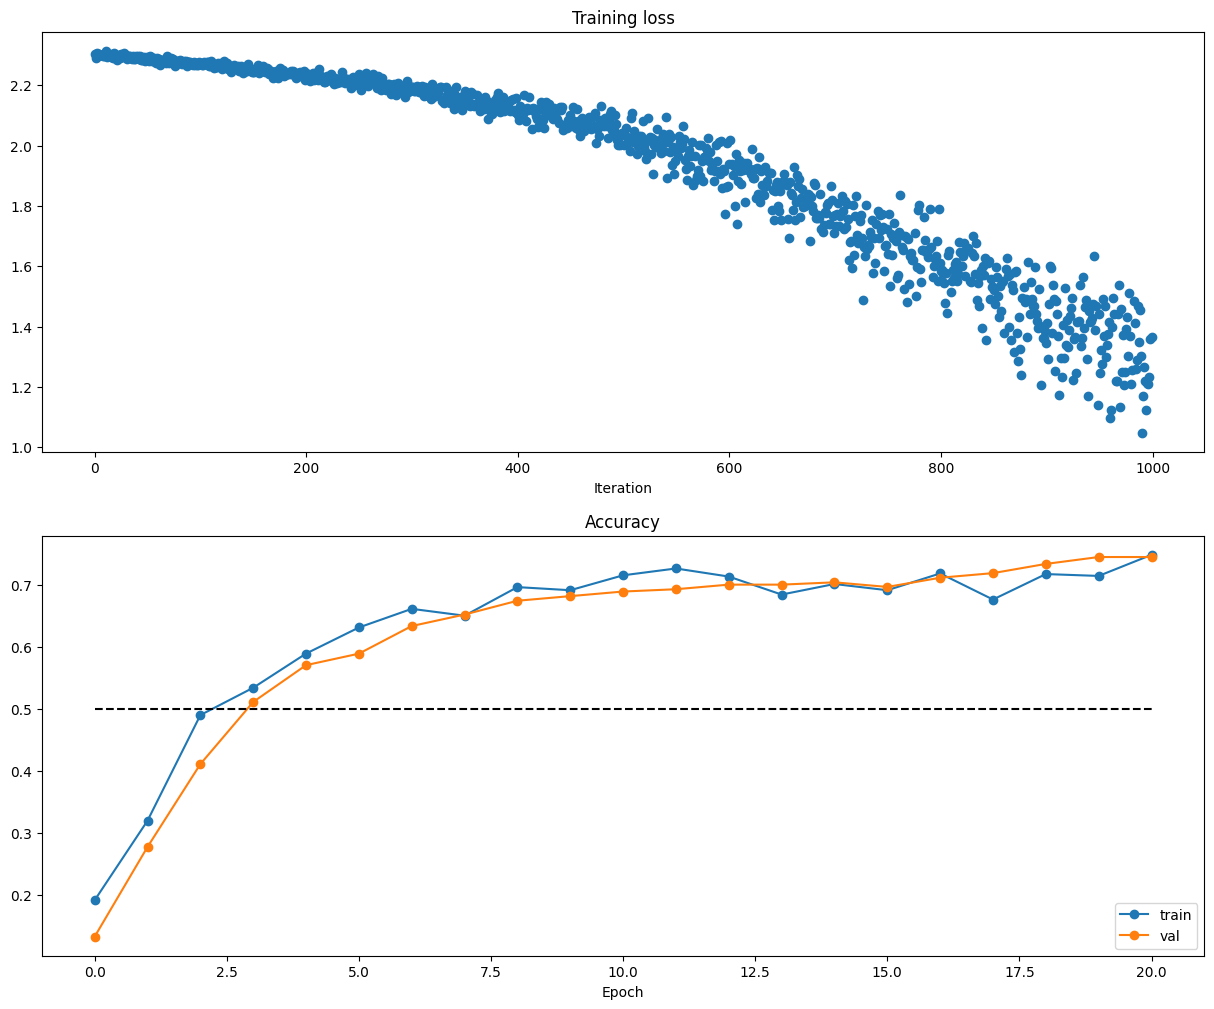

In [122]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

Теперь реализуйте полносвязную сеть с произвольным числом скрытых слоев. Ознакомьтесь с классом FullyConnectedNet в scripts/classifiers/fc_net.py . Реализуйте инициализацию, прямой и обратный проходы.

In [123]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch/layer normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=3 * 32 * 32, num_classes=10, 
                 dropout=1, normalization=None, reg=0.0, weight_scale=1e-2, dtype=np.float32, seed=None,):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
          are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # реализовали инициализацию, также как и 2-слойной
        D_H_C_dims = [input_dim] + hidden_dims + [num_classes]
        
        for idx in range(self.num_layers):
            nrows = D_H_C_dims[idx]
            ncols = D_H_C_dims[idx+1]

            layer_name = "%d" % (idx+1)
            weight_name = "W" + layer_name
            bias_name = "b" + layer_name
            self.params[weight_name] = weight_scale * np.random.randn(nrows, ncols)
            self.params[bias_name] = np.zeros(ncols)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout}
            if seed is not None:
                self.dropout_param["seed"] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]
        if self.normalization == "layernorm":
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        caches = {}
        scores = X
        # прямой проход реализовали...
        for i in range(1, self.num_layers + 1):
            layer_name = "%d" % i
            W_name = "W" + layer_name
            b_name = "b" + layer_name
            cache_name = "cache" + layer_name
      
            if self.num_layers == i:
                scores, cache = affine_forward(scores, self.params[W_name], self.params[b_name])

            else:
                scores, cache = affine_relu_forward(scores, self.params[W_name], self.params[b_name])
  
            caches[cache_name] = cache

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == "test":
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        grads = {}
        loss, dx = softmax_loss(scores, y)
        # обратный проход
        for i in range(self.num_layers, 0, -1):
            layer_name = "%d" % i
            W_name = "W" + layer_name
            b_name = "b" + layer_name
            cache_name = "cache" + layer_name
      
            loss += 0.5 * self.reg * (self.params[W_name] ** 2).sum()
      
            if self.num_layers == i:
                dx, grads[W_name], grads[b_name] = affine_backward(dx, caches[cache_name])
                
            else:
                (dx, grads[W_name], grads[b_name]) = affine_relu_backward(dx, caches[cache_name])

            grads[W_name] += self.reg * self.params[W_name]


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

In [124]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
  
  # Most of the errors should be on the order of e-7 or smaller.   
  # NOTE: It is fine however to see an error for W2 on the order of e-5
  # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


Попробуйте добиться эффекта переобучения на небольшом наборе изображений (например, 50). Используйте трехслойную сеть со 100 нейронами на каждом скрытом слое. Попробуйте переобучить сеть, достигнув 100 % accuracy за 20 эпох. Для этого поэкспериментируйте с параметрами weight_scale и learning_rate. 

(Iteration 1 / 40) loss: 4.472249
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.237037
(Epoch 1 / 20) train acc: 0.360000; val_acc: 0.196296
(Epoch 2 / 20) train acc: 0.400000; val_acc: 0.322222
(Epoch 3 / 20) train acc: 0.800000; val_acc: 0.522222
(Epoch 4 / 20) train acc: 0.840000; val_acc: 0.625926
(Epoch 5 / 20) train acc: 0.920000; val_acc: 0.670370
(Iteration 11 / 40) loss: 0.101610
(Epoch 6 / 20) train acc: 0.980000; val_acc: 0.707407
(Epoch 7 / 20) train acc: 0.980000; val_acc: 0.781481
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.766667
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.762963
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.755556
(Iteration 21 / 40) loss: 0.007102
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.751852
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.762963
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.777778
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.781481
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.781481
(Iteration 31 / 40) loss: 

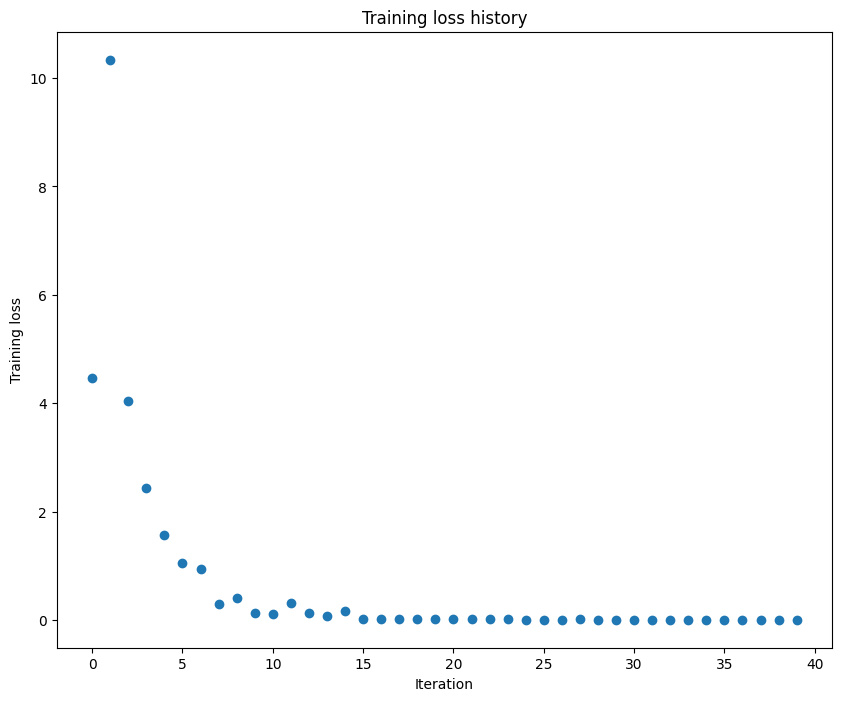

In [125]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-1   # Experiment with this!
learning_rate = 3e-1  # Experiment with this!
model = FullyConnectedNet([100, 100], input_dim=8*8, weight_scale=weight_scale, dtype=np.float64)

solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Повторите эксперимент, описанный выше, для пятислойной сети.

(Iteration 1 / 40) loss: 2.440717
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.100000
(Epoch 1 / 20) train acc: 0.220000; val_acc: 0.122222
(Epoch 2 / 20) train acc: 0.280000; val_acc: 0.192593
(Epoch 3 / 20) train acc: 0.400000; val_acc: 0.174074
(Epoch 4 / 20) train acc: 0.600000; val_acc: 0.229630
(Epoch 5 / 20) train acc: 0.660000; val_acc: 0.311111
(Iteration 11 / 40) loss: 1.335770
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.277778
(Epoch 7 / 20) train acc: 0.800000; val_acc: 0.333333
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.348148
(Epoch 9 / 20) train acc: 0.880000; val_acc: 0.440741
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.462963
(Iteration 21 / 40) loss: 1.121847
(Epoch 11 / 20) train acc: 0.920000; val_acc: 0.522222
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.551852
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.551852
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.555556
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.555556
(Iteration 31 / 40) loss: 

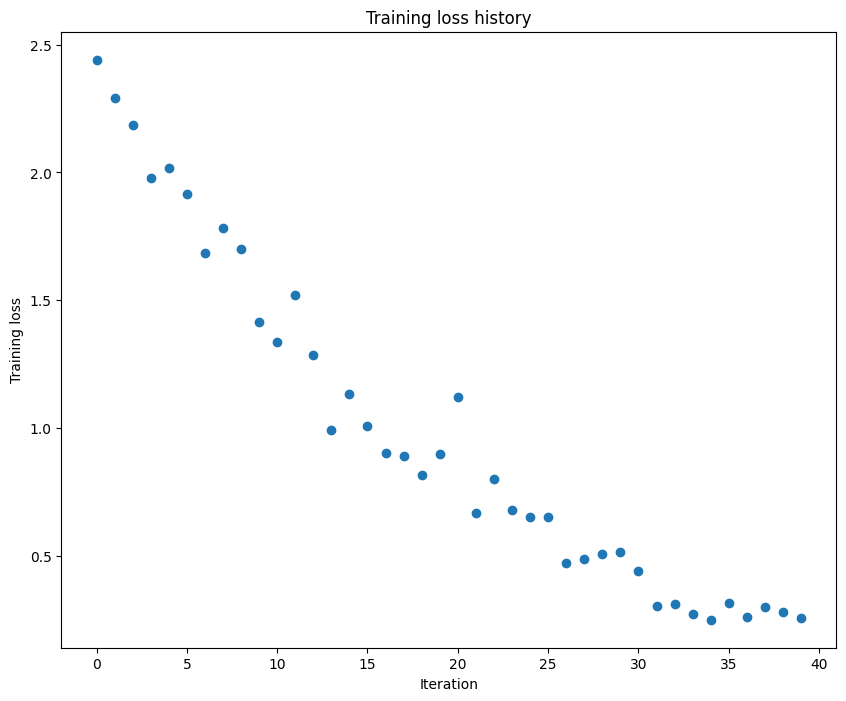

In [129]:
### TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 2e-2  # Experiment with this!
weight_scale = 1e-1   # Experiment with this!
model = FullyConnectedNet([100, 100, 100, 100], input_dim=8*8, weight_scale=weight_scale, dtype=np.float64)

solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Сделайте выводы по проведенному эксперименту. 

* 5 слойная сеть переобучается сильнее, чем 3=з слойная, результаты на валидационной выборке хуже. Вполне логично - больше нейронов - бошьше деталей запоминаем, тем более учитывая, что всего 50 изображений.
* Однако в 5-ти слойной больше весов и переобучение достигается на более поздней эпохе в боих случаях (1. Если говорить о достижени 1 acc на трейне (13 и 8 эпоха соотвественно)и 2. когда acc на трейне существенно больше, чем на вале (примерно 3 и 1 эпоха))

Ранее обновление весов проходило по правилу SGD. Теперь попробуйте реализовать стохастический градиентный спуск с импульсом (SGD+momentum). http://cs231n.github.io/neural-networks-3/#sgd Реализуйте sgd_momentum в scripts/optim.py  и запустите проверку. 

In [130]:
from optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


#### Допустимое отклонение

Сравните результаты обучения шестислойной сети, обученной классическим градиентным спуском и адаптивным алгоритмом с импульсом. Какой алгоритм сходится быстрее.

running with  sgd
(Iteration 1 / 60) loss: 2.303256
(Epoch 0 / 5) train acc: 0.109000; val_acc: 0.118519
(Iteration 11 / 60) loss: 2.302236
(Epoch 1 / 5) train acc: 0.117000; val_acc: 0.122222
(Iteration 21 / 60) loss: 2.302204
(Epoch 2 / 5) train acc: 0.125000; val_acc: 0.114815
(Iteration 31 / 60) loss: 2.301196
(Epoch 3 / 5) train acc: 0.144000; val_acc: 0.125926
(Iteration 41 / 60) loss: 2.302415
(Epoch 4 / 5) train acc: 0.144000; val_acc: 0.129630
(Iteration 51 / 60) loss: 2.301924
(Epoch 5 / 5) train acc: 0.161000; val_acc: 0.133333

running with  sgd_momentum
(Iteration 1 / 60) loss: 2.304511
(Epoch 0 / 5) train acc: 0.143000; val_acc: 0.133333
(Iteration 11 / 60) loss: 2.302130
(Epoch 1 / 5) train acc: 0.152000; val_acc: 0.155556
(Iteration 21 / 60) loss: 2.300973
(Epoch 2 / 5) train acc: 0.221000; val_acc: 0.196296
(Iteration 31 / 60) loss: 2.298543
(Epoch 3 / 5) train acc: 0.284000; val_acc: 0.251852
(Iteration 41 / 60) loss: 2.295510
(Epoch 4 / 5) train acc: 0.285000; val_ac

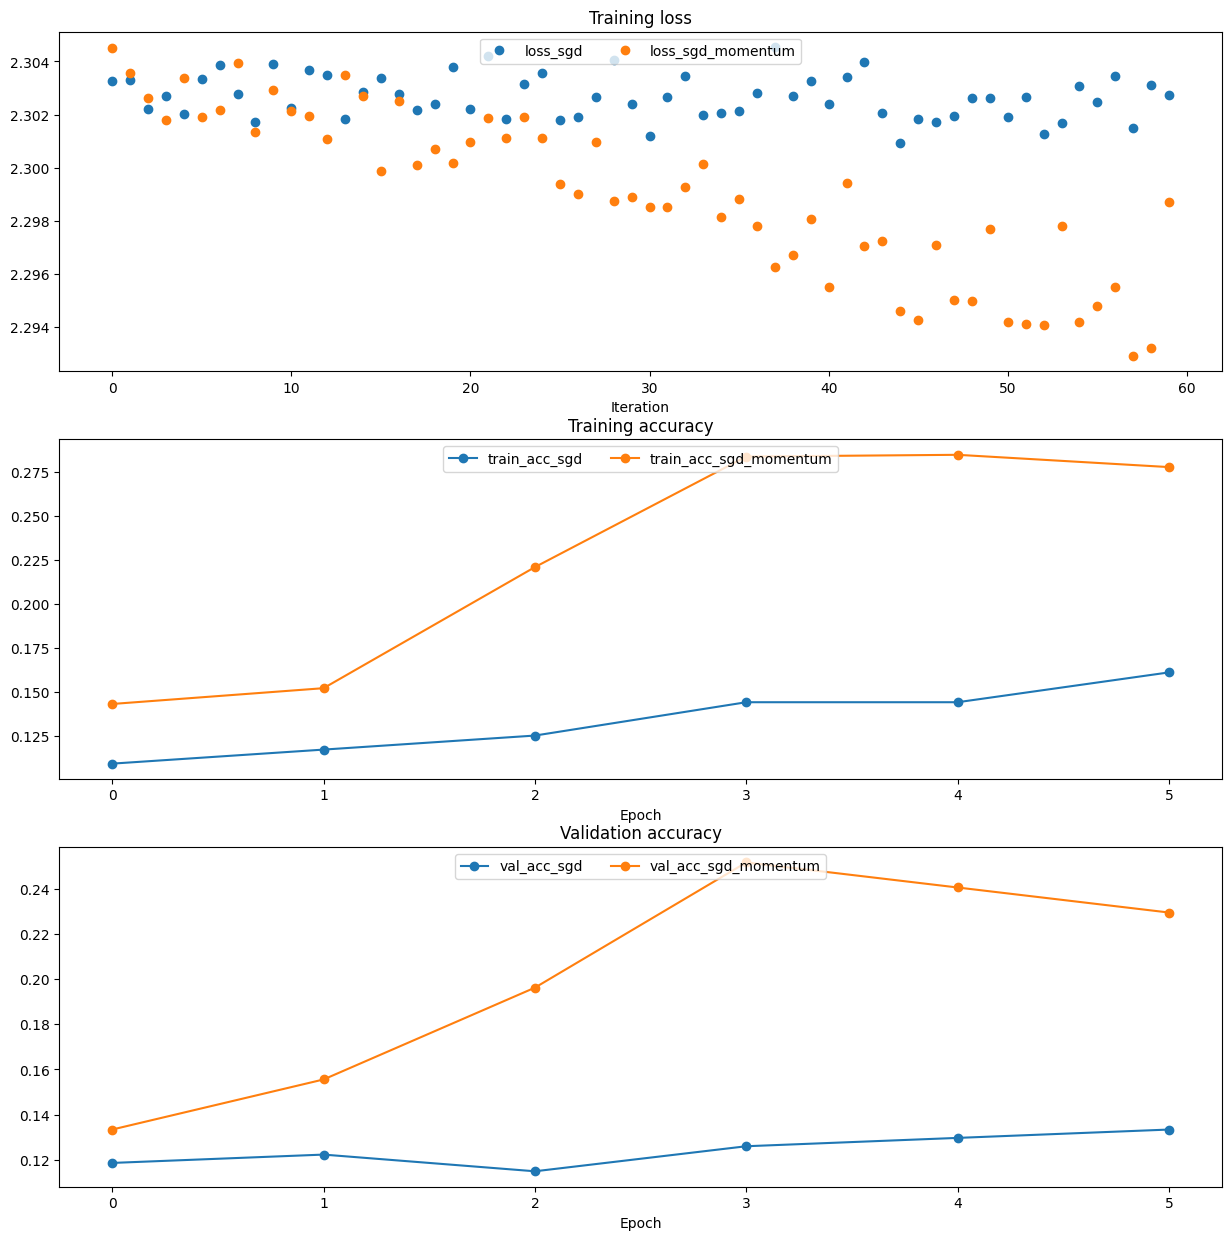

In [131]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], input_dim=8*8, weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

#### sgd_momentum сходится быстрее, что еще сказать

Реализуйте алгоритмы RMSProp [1] and Adam [2] с коррекцией смещения  - методы rmsprop и adam . 


[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [132]:
# Test RMSProp implementation
from optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [133]:
# Test Adam implementation
from optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


#### Получилось нормально

Обучите пару глубоких сетей с испольованием RMSProp и Adam алгоритмов обновления весов и сравните результаты обучения.

running with  adam
(Iteration 1 / 60) loss: 2.302311
(Epoch 0 / 5) train acc: 0.211000; val_acc: 0.155556
(Iteration 11 / 60) loss: 2.160951
(Epoch 1 / 5) train acc: 0.607000; val_acc: 0.670370
(Iteration 21 / 60) loss: 1.513395
(Epoch 2 / 5) train acc: 0.770000; val_acc: 0.781481
(Iteration 31 / 60) loss: 0.742625
(Epoch 3 / 5) train acc: 0.860000; val_acc: 0.877778
(Iteration 41 / 60) loss: 0.443268
(Epoch 4 / 5) train acc: 0.927000; val_acc: 0.918519
(Iteration 51 / 60) loss: 0.307414
(Epoch 5 / 5) train acc: 0.936000; val_acc: 0.914815

running with  rmsprop
(Iteration 1 / 60) loss: 2.300542
(Epoch 0 / 5) train acc: 0.165000; val_acc: 0.192593
(Iteration 11 / 60) loss: 2.224302
(Epoch 1 / 5) train acc: 0.546000; val_acc: 0.544444
(Iteration 21 / 60) loss: 2.054434
(Epoch 2 / 5) train acc: 0.671000; val_acc: 0.688889
(Iteration 31 / 60) loss: 1.911646
(Epoch 3 / 5) train acc: 0.696000; val_acc: 0.737037
(Iteration 41 / 60) loss: 1.461077
(Epoch 4 / 5) train acc: 0.737000; val_acc: 0

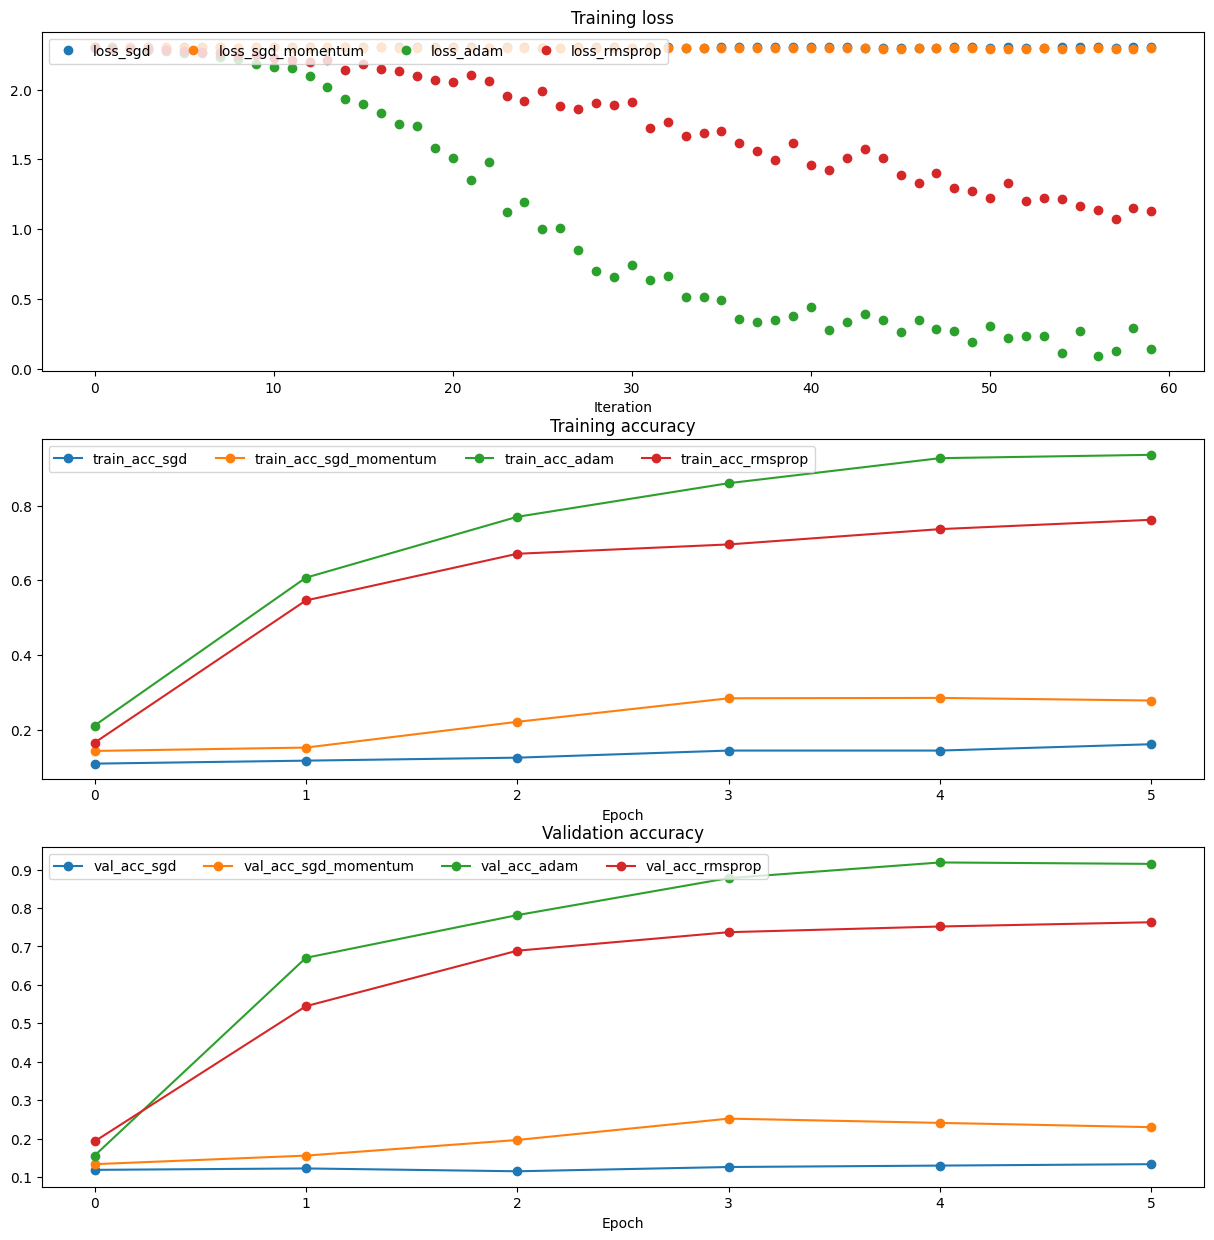

In [134]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], input_dim=8*8, weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper left', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

#### Разница при использовании sgd алгоритмов или более продвинутых алгоритмов сразу же видна. Вторые показывают гораздо лучшие параметры

#### Результаты, кстати, коррелируют со статьей: адам лучше, чем rmsprop, он в свою очередь лучше sgd_momentum, а тот лучше обычного sgd

Получите лучшую полносвязную сеть для классификации вашего набора данных. На наборе CIFAR-10 необходимо получить accuracy не ниже 50 % на валидационном наборе.

In [135]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find batch/layer normalization and dropout useful. Store your best model in  #
# the best_model variable.                                                     #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
best_accuracy = 0.0

weight_scale = 1e-4

layers = [[100, 100],[100, 100, 100], [100, 100, 100, 100]]

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]

regs = [1e-3, 5e-4, 5e-5]

decay = [0.9, 0.95, 1.0]

for layer in layers:
    for lr in learning_rates:
        for reg in regs:
            for lrd in decay:
                
                model = FullyConnectedNet(layer, input_dim=8*8, reg=reg, weight_scale=weight_scale)

                solver = Solver(model, data, num_epochs=20, batch_size=100, update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                      'decay_rate': lrd
                    }
                 )
                solver.train()
                if solver.val_acc_history[-1] > best_accuracy:
                    best_accuracy = solver.val_acc_history[-1]
                    best_model = model
                    print(f"\t new best accuracy of {best_accuracy}, Lr: {lr}, reg: {reg}, lrd: {lrd}, layer: {layer} ")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.248000; val_acc: 0.222222
(Iteration 11 / 240) loss: 0.678159
(Epoch 1 / 20) train acc: 0.814000; val_acc: 0.785185
(Iteration 21 / 240) loss: 0.237583
(Epoch 2 / 20) train acc: 0.953000; val_acc: 0.911111
(Iteration 31 / 240) loss: 0.175919
(Epoch 3 / 20) train acc: 0.965000; val_acc: 0.933333
(Iteration 41 / 240) loss: 0.211086
(Epoch 4 / 20) train acc: 0.960000; val_acc: 0.948148
(Iteration 51 / 240) loss: 0.119123
(Epoch 5 / 20) train acc: 0.976000; val_acc: 0.970370
(Iteration 61 / 240) loss: 0.064417
(Iteration 71 / 240) loss: 0.141997
(Epoch 6 / 20) train acc: 0.983000; val_acc: 0.962963
(Iteration 81 / 240) loss: 0.081849
(Epoch 7 / 20) train acc: 0.997000; val_acc: 0.951852
(Iteration 91 / 240) loss: 0.062136
(Epoch 8 / 20) train acc: 1.000000; val_acc: 0.966667
(Iteration 101 / 240) loss: 0.057409
(Epoch 9 / 20) train acc: 0.999000; val_acc: 0.970370
(Iteration 111 / 240) loss: 0.056269
(Epoch 10 / 20) train acc: 

(Iteration 11 / 240) loss: 0.609362
(Epoch 1 / 20) train acc: 0.860000; val_acc: 0.859259
(Iteration 21 / 240) loss: 0.247143
(Epoch 2 / 20) train acc: 0.953000; val_acc: 0.937037
(Iteration 31 / 240) loss: 0.141260
(Epoch 3 / 20) train acc: 0.962000; val_acc: 0.929630
(Iteration 41 / 240) loss: 0.212812
(Epoch 4 / 20) train acc: 0.972000; val_acc: 0.959259
(Iteration 51 / 240) loss: 0.062067
(Epoch 5 / 20) train acc: 0.981000; val_acc: 0.959259
(Iteration 61 / 240) loss: 0.456802
(Iteration 71 / 240) loss: 0.134245
(Epoch 6 / 20) train acc: 0.994000; val_acc: 0.966667
(Iteration 81 / 240) loss: 0.041981
(Epoch 7 / 20) train acc: 0.986000; val_acc: 0.962963
(Iteration 91 / 240) loss: 0.031967
(Epoch 8 / 20) train acc: 0.994000; val_acc: 0.966667
(Iteration 101 / 240) loss: 0.048894
(Epoch 9 / 20) train acc: 0.987000; val_acc: 0.944444
(Iteration 111 / 240) loss: 0.042430
(Epoch 10 / 20) train acc: 0.996000; val_acc: 0.948148
(Iteration 121 / 240) loss: 0.052579
(Iteration 131 / 240) lo

(Epoch 2 / 20) train acc: 0.886000; val_acc: 0.881481
(Iteration 31 / 240) loss: 0.195483
(Epoch 3 / 20) train acc: 0.964000; val_acc: 0.948148
(Iteration 41 / 240) loss: 0.044289
(Epoch 4 / 20) train acc: 0.978000; val_acc: 0.966667
(Iteration 51 / 240) loss: 0.022917
(Epoch 5 / 20) train acc: 0.976000; val_acc: 0.944444
(Iteration 61 / 240) loss: 0.066151
(Iteration 71 / 240) loss: 0.048444
(Epoch 6 / 20) train acc: 0.987000; val_acc: 0.970370
(Iteration 81 / 240) loss: 0.055862
(Epoch 7 / 20) train acc: 0.990000; val_acc: 0.966667
(Iteration 91 / 240) loss: 0.028990
(Epoch 8 / 20) train acc: 0.993000; val_acc: 0.962963
(Iteration 101 / 240) loss: 0.041243
(Epoch 9 / 20) train acc: 0.991000; val_acc: 0.974074
(Iteration 111 / 240) loss: 0.011423
(Epoch 10 / 20) train acc: 0.991000; val_acc: 0.955556
(Iteration 121 / 240) loss: 0.009118
(Iteration 131 / 240) loss: 0.085422
(Epoch 11 / 20) train acc: 0.996000; val_acc: 0.959259
(Iteration 141 / 240) loss: 0.009119
(Epoch 12 / 20) train

(Iteration 41 / 240) loss: 1.444766
(Epoch 4 / 20) train acc: 0.421000; val_acc: 0.388889
(Iteration 51 / 240) loss: 1.456933
(Epoch 5 / 20) train acc: 0.569000; val_acc: 0.503704
(Iteration 61 / 240) loss: 1.144252
(Iteration 71 / 240) loss: 0.959704
(Epoch 6 / 20) train acc: 0.676000; val_acc: 0.666667
(Iteration 81 / 240) loss: 0.873468
(Epoch 7 / 20) train acc: 0.754000; val_acc: 0.748148
(Iteration 91 / 240) loss: 0.709943
(Epoch 8 / 20) train acc: 0.777000; val_acc: 0.803704
(Iteration 101 / 240) loss: 0.600086
(Epoch 9 / 20) train acc: 0.837000; val_acc: 0.822222
(Iteration 111 / 240) loss: 0.347453
(Epoch 10 / 20) train acc: 0.861000; val_acc: 0.859259
(Iteration 121 / 240) loss: 0.382961
(Iteration 131 / 240) loss: 0.222447
(Epoch 11 / 20) train acc: 0.951000; val_acc: 0.940741
(Iteration 141 / 240) loss: 0.227292
(Epoch 12 / 20) train acc: 0.966000; val_acc: 0.937037
(Iteration 151 / 240) loss: 0.130169
(Epoch 13 / 20) train acc: 0.973000; val_acc: 0.951852
(Iteration 161 / 2

(Epoch 10 / 20) train acc: 0.925000; val_acc: 0.918519
(Iteration 121 / 240) loss: 0.212949
(Iteration 131 / 240) loss: 0.168871
(Epoch 11 / 20) train acc: 0.948000; val_acc: 0.937037
(Iteration 141 / 240) loss: 0.158624
(Epoch 12 / 20) train acc: 0.957000; val_acc: 0.937037
(Iteration 151 / 240) loss: 0.067441
(Epoch 13 / 20) train acc: 0.975000; val_acc: 0.955556
(Iteration 161 / 240) loss: 0.096313
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.959259
(Iteration 171 / 240) loss: 0.085639
(Epoch 15 / 20) train acc: 0.992000; val_acc: 0.962963
(Iteration 181 / 240) loss: 0.043719
(Iteration 191 / 240) loss: 0.066788
(Epoch 16 / 20) train acc: 0.983000; val_acc: 0.955556
(Iteration 201 / 240) loss: 0.033156
(Epoch 17 / 20) train acc: 0.995000; val_acc: 0.955556
(Iteration 211 / 240) loss: 0.032290
(Epoch 18 / 20) train acc: 0.992000; val_acc: 0.962963
(Iteration 221 / 240) loss: 0.046043
(Epoch 19 / 20) train acc: 0.996000; val_acc: 0.959259
(Iteration 231 / 240) loss: 0.019425
(Epoch

(Epoch 15 / 20) train acc: 0.179000; val_acc: 0.111111
(Iteration 181 / 240) loss: 2.067043
(Iteration 191 / 240) loss: 1.978832
(Epoch 16 / 20) train acc: 0.192000; val_acc: 0.118519
(Iteration 201 / 240) loss: 2.083101
(Epoch 17 / 20) train acc: 0.182000; val_acc: 0.118519
(Iteration 211 / 240) loss: 1.948319
(Epoch 18 / 20) train acc: 0.163000; val_acc: 0.118519
(Iteration 221 / 240) loss: 1.942072
(Epoch 19 / 20) train acc: 0.177000; val_acc: 0.118519
(Iteration 231 / 240) loss: 1.994814
(Epoch 20 / 20) train acc: 0.197000; val_acc: 0.118519
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.099000; val_acc: 0.066667
(Iteration 11 / 240) loss: 2.302553
(Epoch 1 / 20) train acc: 0.117000; val_acc: 0.074074
(Iteration 21 / 240) loss: 2.302351
(Epoch 2 / 20) train acc: 0.111000; val_acc: 0.074074
(Iteration 31 / 240) loss: 2.301464
(Epoch 3 / 20) train acc: 0.158000; val_acc: 0.122222
(Iteration 41 / 240) loss: 2.298717
(Epoch 4 / 20) train acc: 0.223000; val_acc: 0.155556

(Iteration 231 / 240) loss: 1.615187
(Epoch 20 / 20) train acc: 0.438000; val_acc: 0.403704
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.079000; val_acc: 0.129630
(Iteration 11 / 240) loss: 2.302645
(Epoch 1 / 20) train acc: 0.199000; val_acc: 0.185185
(Iteration 21 / 240) loss: 2.302391
(Epoch 2 / 20) train acc: 0.217000; val_acc: 0.188889
(Iteration 31 / 240) loss: 2.301785
(Epoch 3 / 20) train acc: 0.209000; val_acc: 0.188889
(Iteration 41 / 240) loss: 2.298809
(Epoch 4 / 20) train acc: 0.210000; val_acc: 0.188889
(Iteration 51 / 240) loss: 2.293091
(Epoch 5 / 20) train acc: 0.269000; val_acc: 0.214815
(Iteration 61 / 240) loss: 2.283401
(Iteration 71 / 240) loss: 2.270462
(Epoch 6 / 20) train acc: 0.267000; val_acc: 0.218519
(Iteration 81 / 240) loss: 2.228772
(Epoch 7 / 20) train acc: 0.248000; val_acc: 0.211111
(Iteration 91 / 240) loss: 2.194137
(Epoch 8 / 20) train acc: 0.228000; val_acc: 0.203704
(Iteration 101 / 240) loss: 2.114769
(Epoch 9 / 20) train acc: 

(Iteration 31 / 240) loss: 2.302589
(Epoch 3 / 20) train acc: 0.113000; val_acc: 0.096296
(Iteration 41 / 240) loss: 2.302574
(Epoch 4 / 20) train acc: 0.105000; val_acc: 0.111111
(Iteration 51 / 240) loss: 2.302587
(Epoch 5 / 20) train acc: 0.095000; val_acc: 0.111111
(Iteration 61 / 240) loss: 2.302585
(Iteration 71 / 240) loss: 2.302582
(Epoch 6 / 20) train acc: 0.104000; val_acc: 0.111111
(Iteration 81 / 240) loss: 2.302549
(Epoch 7 / 20) train acc: 0.201000; val_acc: 0.174074
(Iteration 91 / 240) loss: 2.302514
(Epoch 8 / 20) train acc: 0.183000; val_acc: 0.174074
(Iteration 101 / 240) loss: 2.302477
(Epoch 9 / 20) train acc: 0.199000; val_acc: 0.174074
(Iteration 111 / 240) loss: 2.302433
(Epoch 10 / 20) train acc: 0.205000; val_acc: 0.181481
(Iteration 121 / 240) loss: 2.302400
(Iteration 131 / 240) loss: 2.302358
(Epoch 11 / 20) train acc: 0.223000; val_acc: 0.185185
(Iteration 141 / 240) loss: 2.302073
(Epoch 12 / 20) train acc: 0.203000; val_acc: 0.192593
(Iteration 151 / 240

(Epoch 8 / 20) train acc: 0.220000; val_acc: 0.185185
(Iteration 101 / 240) loss: 2.302425
(Epoch 9 / 20) train acc: 0.205000; val_acc: 0.185185
(Iteration 111 / 240) loss: 2.302337
(Epoch 10 / 20) train acc: 0.204000; val_acc: 0.185185
(Iteration 121 / 240) loss: 2.302285
(Iteration 131 / 240) loss: 2.302067
(Epoch 11 / 20) train acc: 0.205000; val_acc: 0.185185
(Iteration 141 / 240) loss: 2.301999
(Epoch 12 / 20) train acc: 0.196000; val_acc: 0.185185
(Iteration 151 / 240) loss: 2.301672
(Epoch 13 / 20) train acc: 0.211000; val_acc: 0.188889
(Iteration 161 / 240) loss: 2.301459
(Epoch 14 / 20) train acc: 0.262000; val_acc: 0.240741
(Iteration 171 / 240) loss: 2.301203
(Epoch 15 / 20) train acc: 0.260000; val_acc: 0.259259
(Iteration 181 / 240) loss: 2.300835
(Iteration 191 / 240) loss: 2.299735
(Epoch 16 / 20) train acc: 0.263000; val_acc: 0.251852
(Iteration 201 / 240) loss: 2.299773
(Epoch 17 / 20) train acc: 0.270000; val_acc: 0.233333
(Iteration 211 / 240) loss: 2.299062
(Epoch 1

(Epoch 10 / 20) train acc: 0.988000; val_acc: 0.970370
(Iteration 121 / 240) loss: 0.078724
(Iteration 131 / 240) loss: 0.113843
(Epoch 11 / 20) train acc: 0.971000; val_acc: 0.929630
(Iteration 141 / 240) loss: 0.244090
(Epoch 12 / 20) train acc: 0.976000; val_acc: 0.937037
(Iteration 151 / 240) loss: 0.159674
(Epoch 13 / 20) train acc: 0.967000; val_acc: 0.937037
(Iteration 161 / 240) loss: 0.189798
(Epoch 14 / 20) train acc: 0.992000; val_acc: 0.966667
(Iteration 171 / 240) loss: 0.136002
(Epoch 15 / 20) train acc: 0.990000; val_acc: 0.970370
(Iteration 181 / 240) loss: 0.098185
(Iteration 191 / 240) loss: 0.098925
(Epoch 16 / 20) train acc: 0.994000; val_acc: 0.970370
(Iteration 201 / 240) loss: 0.100860
(Epoch 17 / 20) train acc: 0.988000; val_acc: 0.970370
(Iteration 211 / 240) loss: 0.095114
(Epoch 18 / 20) train acc: 0.990000; val_acc: 0.977778
(Iteration 221 / 240) loss: 0.106045
(Epoch 19 / 20) train acc: 1.000000; val_acc: 0.970370
(Iteration 231 / 240) loss: 0.087704
(Epoch

(Epoch 16 / 20) train acc: 0.994000; val_acc: 0.966667
(Iteration 201 / 240) loss: 0.057871
(Epoch 17 / 20) train acc: 0.996000; val_acc: 0.959259
(Iteration 211 / 240) loss: 0.054195
(Epoch 18 / 20) train acc: 0.991000; val_acc: 0.944444
(Iteration 221 / 240) loss: 0.235076
(Epoch 19 / 20) train acc: 0.999000; val_acc: 0.944444
(Iteration 231 / 240) loss: 0.059509
(Epoch 20 / 20) train acc: 0.984000; val_acc: 0.951852
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.112000; val_acc: 0.114815
(Iteration 11 / 240) loss: 1.860222
(Epoch 1 / 20) train acc: 0.213000; val_acc: 0.185185
(Iteration 21 / 240) loss: 1.424981
(Epoch 2 / 20) train acc: 0.543000; val_acc: 0.537037
(Iteration 31 / 240) loss: 0.952792
(Epoch 3 / 20) train acc: 0.795000; val_acc: 0.748148
(Iteration 41 / 240) loss: 0.492170
(Epoch 4 / 20) train acc: 0.924000; val_acc: 0.903704
(Iteration 51 / 240) loss: 0.349727
(Epoch 5 / 20) train acc: 0.962000; val_acc: 0.933333
(Iteration 61 / 240) loss: 0.059507
(I

(Epoch 20 / 20) train acc: 0.304000; val_acc: 0.281481
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.095000; val_acc: 0.129630
(Iteration 11 / 240) loss: 2.303036
(Epoch 1 / 20) train acc: 0.108000; val_acc: 0.096296
(Iteration 21 / 240) loss: 2.303057
(Epoch 2 / 20) train acc: 0.096000; val_acc: 0.074074
(Iteration 31 / 240) loss: 2.302350
(Epoch 3 / 20) train acc: 0.093000; val_acc: 0.129630
(Iteration 41 / 240) loss: 2.301447
(Epoch 4 / 20) train acc: 0.090000; val_acc: 0.129630
(Iteration 51 / 240) loss: 2.298455
(Epoch 5 / 20) train acc: 0.097000; val_acc: 0.081481
(Iteration 61 / 240) loss: 2.293188
(Iteration 71 / 240) loss: 2.288393
(Epoch 6 / 20) train acc: 0.099000; val_acc: 0.066667
(Iteration 81 / 240) loss: 2.275762
(Epoch 7 / 20) train acc: 0.130000; val_acc: 0.066667
(Iteration 91 / 240) loss: 2.262031
(Epoch 8 / 20) train acc: 0.087000; val_acc: 0.066667
(Iteration 101 / 240) loss: 2.248558
(Epoch 9 / 20) train acc: 0.105000; val_acc: 0.066667
(Iteratio

(Epoch 1 / 20) train acc: 0.118000; val_acc: 0.066667
(Iteration 21 / 240) loss: 2.302046
(Epoch 2 / 20) train acc: 0.118000; val_acc: 0.066667
(Iteration 31 / 240) loss: 2.302792
(Epoch 3 / 20) train acc: 0.098000; val_acc: 0.096296
(Iteration 41 / 240) loss: 2.302227
(Epoch 4 / 20) train acc: 0.096000; val_acc: 0.074074
(Iteration 51 / 240) loss: 2.306249
(Epoch 5 / 20) train acc: 0.107000; val_acc: 0.074074
(Iteration 61 / 240) loss: 2.303658
(Iteration 71 / 240) loss: 2.308274
(Epoch 6 / 20) train acc: 0.099000; val_acc: 0.074074
(Iteration 81 / 240) loss: 2.301665
(Epoch 7 / 20) train acc: 0.118000; val_acc: 0.096296
(Iteration 91 / 240) loss: 2.302611
(Epoch 8 / 20) train acc: 0.093000; val_acc: 0.096296
(Iteration 101 / 240) loss: 2.295333
(Epoch 9 / 20) train acc: 0.100000; val_acc: 0.096296
(Iteration 111 / 240) loss: 2.305792
(Epoch 10 / 20) train acc: 0.125000; val_acc: 0.096296
(Iteration 121 / 240) loss: 2.296330
(Iteration 131 / 240) loss: 2.297929
(Epoch 11 / 20) train a

(Epoch 6 / 20) train acc: 0.102000; val_acc: 0.066667
(Iteration 81 / 240) loss: 2.302434
(Epoch 7 / 20) train acc: 0.118000; val_acc: 0.066667
(Iteration 91 / 240) loss: 2.302454
(Epoch 8 / 20) train acc: 0.106000; val_acc: 0.066667
(Iteration 101 / 240) loss: 2.302589
(Epoch 9 / 20) train acc: 0.116000; val_acc: 0.066667
(Iteration 111 / 240) loss: 2.302097
(Epoch 10 / 20) train acc: 0.101000; val_acc: 0.066667
(Iteration 121 / 240) loss: 2.302317
(Iteration 131 / 240) loss: 2.302730
(Epoch 11 / 20) train acc: 0.080000; val_acc: 0.066667
(Iteration 141 / 240) loss: 2.302907
(Epoch 12 / 20) train acc: 0.087000; val_acc: 0.066667
(Iteration 151 / 240) loss: 2.302168
(Epoch 13 / 20) train acc: 0.108000; val_acc: 0.066667
(Iteration 161 / 240) loss: 2.302504
(Epoch 14 / 20) train acc: 0.094000; val_acc: 0.066667
(Iteration 171 / 240) loss: 2.302064
(Epoch 15 / 20) train acc: 0.095000; val_acc: 0.066667
(Iteration 181 / 240) loss: 2.302468
(Iteration 191 / 240) loss: 2.303246
(Epoch 16 / 

(Epoch 10 / 20) train acc: 0.100000; val_acc: 0.096296
(Iteration 121 / 240) loss: 2.302143
(Iteration 131 / 240) loss: 2.302483
(Epoch 11 / 20) train acc: 0.105000; val_acc: 0.096296
(Iteration 141 / 240) loss: 2.302878
(Epoch 12 / 20) train acc: 0.115000; val_acc: 0.096296
(Iteration 151 / 240) loss: 2.302320
(Epoch 13 / 20) train acc: 0.114000; val_acc: 0.096296
(Iteration 161 / 240) loss: 2.302075
(Epoch 14 / 20) train acc: 0.099000; val_acc: 0.096296
(Iteration 171 / 240) loss: 2.302349
(Epoch 15 / 20) train acc: 0.109000; val_acc: 0.096296
(Iteration 181 / 240) loss: 2.302238
(Iteration 191 / 240) loss: 2.301613
(Epoch 16 / 20) train acc: 0.116000; val_acc: 0.074074
(Iteration 201 / 240) loss: 2.302158
(Epoch 17 / 20) train acc: 0.104000; val_acc: 0.074074
(Iteration 211 / 240) loss: 2.302456
(Epoch 18 / 20) train acc: 0.091000; val_acc: 0.074074
(Iteration 221 / 240) loss: 2.301992
(Epoch 19 / 20) train acc: 0.090000; val_acc: 0.096296
(Iteration 231 / 240) loss: 2.302149
(Epoch

(Epoch 12 / 20) train acc: 0.120000; val_acc: 0.066667
(Iteration 151 / 240) loss: 2.303009
(Epoch 13 / 20) train acc: 0.110000; val_acc: 0.096296
(Iteration 161 / 240) loss: 2.301979
(Epoch 14 / 20) train acc: 0.110000; val_acc: 0.096296
(Iteration 171 / 240) loss: 2.301723
(Epoch 15 / 20) train acc: 0.085000; val_acc: 0.096296
(Iteration 181 / 240) loss: 2.300812
(Iteration 191 / 240) loss: 2.298431
(Epoch 16 / 20) train acc: 0.101000; val_acc: 0.096296
(Iteration 201 / 240) loss: 2.299264
(Epoch 17 / 20) train acc: 0.110000; val_acc: 0.096296
(Iteration 211 / 240) loss: 2.293583
(Epoch 18 / 20) train acc: 0.120000; val_acc: 0.096296
(Iteration 221 / 240) loss: 2.289972
(Epoch 19 / 20) train acc: 0.100000; val_acc: 0.096296
(Iteration 231 / 240) loss: 2.278803
(Epoch 20 / 20) train acc: 0.101000; val_acc: 0.096296
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.110000; val_acc: 0.074074
(Iteration 11 / 240) loss: 2.302587
(Epoch 1 / 20) train acc: 0.093000; val_acc: 0.

(Epoch 15 / 20) train acc: 0.102000; val_acc: 0.111111
(Iteration 181 / 240) loss: 2.302587
(Iteration 191 / 240) loss: 2.302584
(Epoch 16 / 20) train acc: 0.112000; val_acc: 0.111111
(Iteration 201 / 240) loss: 2.302618
(Epoch 17 / 20) train acc: 0.111000; val_acc: 0.111111
(Iteration 211 / 240) loss: 2.302558
(Epoch 18 / 20) train acc: 0.103000; val_acc: 0.111111
(Iteration 221 / 240) loss: 2.302563
(Epoch 19 / 20) train acc: 0.086000; val_acc: 0.096296
(Iteration 231 / 240) loss: 2.302571
(Epoch 20 / 20) train acc: 0.119000; val_acc: 0.096296
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.109000; val_acc: 0.111111
(Iteration 11 / 240) loss: 2.302581
(Epoch 1 / 20) train acc: 0.115000; val_acc: 0.077778
(Iteration 21 / 240) loss: 2.302593
(Epoch 2 / 20) train acc: 0.110000; val_acc: 0.077778
(Iteration 31 / 240) loss: 2.302596
(Epoch 3 / 20) train acc: 0.086000; val_acc: 0.077778
(Iteration 41 / 240) loss: 2.302580
(Epoch 4 / 20) train acc: 0.106000; val_acc: 0.111111

(Epoch 18 / 20) train acc: 0.101000; val_acc: 0.066667
(Iteration 221 / 240) loss: 2.302495
(Epoch 19 / 20) train acc: 0.105000; val_acc: 0.066667
(Iteration 231 / 240) loss: 2.302545
(Epoch 20 / 20) train acc: 0.107000; val_acc: 0.066667
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.110000; val_acc: 0.103704
(Iteration 11 / 240) loss: 2.302585
(Epoch 1 / 20) train acc: 0.094000; val_acc: 0.103704
(Iteration 21 / 240) loss: 2.302581
(Epoch 2 / 20) train acc: 0.112000; val_acc: 0.103704
(Iteration 31 / 240) loss: 2.302600
(Epoch 3 / 20) train acc: 0.110000; val_acc: 0.103704
(Iteration 41 / 240) loss: 2.302578
(Epoch 4 / 20) train acc: 0.100000; val_acc: 0.077778
(Iteration 51 / 240) loss: 2.302570
(Epoch 5 / 20) train acc: 0.101000; val_acc: 0.077778
(Iteration 61 / 240) loss: 2.302577
(Iteration 71 / 240) loss: 2.302581
(Epoch 6 / 20) train acc: 0.111000; val_acc: 0.077778
(Iteration 81 / 240) loss: 2.302600
(Epoch 7 / 20) train acc: 0.122000; val_acc: 0.077778
(Itera

(Iteration 231 / 240) loss: 0.104639
(Epoch 20 / 20) train acc: 0.971000; val_acc: 0.944444
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.102000; val_acc: 0.066667
(Iteration 11 / 240) loss: 2.061428
(Epoch 1 / 20) train acc: 0.119000; val_acc: 0.074074
(Iteration 21 / 240) loss: 2.033298
(Epoch 2 / 20) train acc: 0.219000; val_acc: 0.166667
(Iteration 31 / 240) loss: 1.962849
(Epoch 3 / 20) train acc: 0.235000; val_acc: 0.214815
(Iteration 41 / 240) loss: 1.801183
(Epoch 4 / 20) train acc: 0.284000; val_acc: 0.285185
(Iteration 51 / 240) loss: 1.531121
(Epoch 5 / 20) train acc: 0.447000; val_acc: 0.355556
(Iteration 61 / 240) loss: 1.220301
(Iteration 71 / 240) loss: 0.855306
(Epoch 6 / 20) train acc: 0.708000; val_acc: 0.666667
(Iteration 81 / 240) loss: 0.451683
(Epoch 7 / 20) train acc: 0.825000; val_acc: 0.729630
(Iteration 91 / 240) loss: 0.345561
(Epoch 8 / 20) train acc: 0.958000; val_acc: 0.940741
(Iteration 101 / 240) loss: 0.130519
(Epoch 9 / 20) train acc: 

(Iteration 31 / 240) loss: 1.779434
(Epoch 3 / 20) train acc: 0.250000; val_acc: 0.211111
(Iteration 41 / 240) loss: 1.591951
(Epoch 4 / 20) train acc: 0.418000; val_acc: 0.440741
(Iteration 51 / 240) loss: 1.429842
(Epoch 5 / 20) train acc: 0.629000; val_acc: 0.681481
(Iteration 61 / 240) loss: 0.939550
(Iteration 71 / 240) loss: 1.102475
(Epoch 6 / 20) train acc: 0.703000; val_acc: 0.714815
(Iteration 81 / 240) loss: 0.315273
(Epoch 7 / 20) train acc: 0.876000; val_acc: 0.877778
(Iteration 91 / 240) loss: 0.293019
(Epoch 8 / 20) train acc: 0.943000; val_acc: 0.951852
(Iteration 101 / 240) loss: 0.225448
(Epoch 9 / 20) train acc: 0.946000; val_acc: 0.944444
(Iteration 111 / 240) loss: 0.318751
(Epoch 10 / 20) train acc: 0.967000; val_acc: 0.922222
(Iteration 121 / 240) loss: 0.140242
(Iteration 131 / 240) loss: 0.025754
(Epoch 11 / 20) train acc: 0.976000; val_acc: 0.951852
(Iteration 141 / 240) loss: 0.047420
(Epoch 12 / 20) train acc: 0.984000; val_acc: 0.962963
(Iteration 151 / 240

(Epoch 4 / 20) train acc: 0.121000; val_acc: 0.096296
(Iteration 51 / 240) loss: 2.302075
(Epoch 5 / 20) train acc: 0.125000; val_acc: 0.096296
(Iteration 61 / 240) loss: 2.302067
(Iteration 71 / 240) loss: 2.301832
(Epoch 6 / 20) train acc: 0.102000; val_acc: 0.096296
(Iteration 81 / 240) loss: 2.301866
(Epoch 7 / 20) train acc: 0.085000; val_acc: 0.096296
(Iteration 91 / 240) loss: 2.304901
(Epoch 8 / 20) train acc: 0.071000; val_acc: 0.111111
(Iteration 101 / 240) loss: 2.301298
(Epoch 9 / 20) train acc: 0.097000; val_acc: 0.111111
(Iteration 111 / 240) loss: 2.302496
(Epoch 10 / 20) train acc: 0.097000; val_acc: 0.074074
(Iteration 121 / 240) loss: 2.303518
(Iteration 131 / 240) loss: 2.302344
(Epoch 11 / 20) train acc: 0.102000; val_acc: 0.111111
(Iteration 141 / 240) loss: 2.301169
(Epoch 12 / 20) train acc: 0.095000; val_acc: 0.074074
(Iteration 151 / 240) loss: 2.302473
(Epoch 13 / 20) train acc: 0.106000; val_acc: 0.096296
(Iteration 161 / 240) loss: 2.297972
(Epoch 14 / 20) t

(Epoch 6 / 20) train acc: 0.121000; val_acc: 0.081481
(Iteration 81 / 240) loss: 1.989614
(Epoch 7 / 20) train acc: 0.177000; val_acc: 0.170370
(Iteration 91 / 240) loss: 1.779165
(Epoch 8 / 20) train acc: 0.169000; val_acc: 0.188889
(Iteration 101 / 240) loss: 1.930339
(Epoch 9 / 20) train acc: 0.187000; val_acc: 0.181481
(Iteration 111 / 240) loss: 1.813772
(Epoch 10 / 20) train acc: 0.176000; val_acc: 0.188889
(Iteration 121 / 240) loss: 1.925376
(Iteration 131 / 240) loss: 1.910441
(Epoch 11 / 20) train acc: 0.230000; val_acc: 0.185185
(Iteration 141 / 240) loss: 1.858629
(Epoch 12 / 20) train acc: 0.221000; val_acc: 0.188889
(Iteration 151 / 240) loss: 1.939782
(Epoch 13 / 20) train acc: 0.199000; val_acc: 0.188889
(Iteration 161 / 240) loss: 1.939303
(Epoch 14 / 20) train acc: 0.216000; val_acc: 0.192593
(Iteration 171 / 240) loss: 1.800961
(Epoch 15 / 20) train acc: 0.208000; val_acc: 0.188889
(Iteration 181 / 240) loss: 1.747274
(Iteration 191 / 240) loss: 1.868692
(Epoch 16 / 

(Iteration 91 / 240) loss: 2.302506
(Epoch 8 / 20) train acc: 0.109000; val_acc: 0.081481
(Iteration 101 / 240) loss: 2.302529
(Epoch 9 / 20) train acc: 0.094000; val_acc: 0.081481
(Iteration 111 / 240) loss: 2.302502
(Epoch 10 / 20) train acc: 0.090000; val_acc: 0.081481
(Iteration 121 / 240) loss: 2.302583
(Iteration 131 / 240) loss: 2.302835
(Epoch 11 / 20) train acc: 0.110000; val_acc: 0.081481
(Iteration 141 / 240) loss: 2.302688
(Epoch 12 / 20) train acc: 0.100000; val_acc: 0.081481
(Iteration 151 / 240) loss: 2.302404
(Epoch 13 / 20) train acc: 0.120000; val_acc: 0.074074
(Iteration 161 / 240) loss: 2.302636
(Epoch 14 / 20) train acc: 0.098000; val_acc: 0.081481
(Iteration 171 / 240) loss: 2.302504
(Epoch 15 / 20) train acc: 0.109000; val_acc: 0.081481
(Iteration 181 / 240) loss: 2.302407
(Iteration 191 / 240) loss: 2.302523
(Epoch 16 / 20) train acc: 0.099000; val_acc: 0.081481
(Iteration 201 / 240) loss: 2.302335
(Epoch 17 / 20) train acc: 0.117000; val_acc: 0.081481
(Iteratio

(Epoch 13 / 20) train acc: 0.094000; val_acc: 0.129630
(Iteration 161 / 240) loss: 2.302756
(Epoch 14 / 20) train acc: 0.086000; val_acc: 0.129630
(Iteration 171 / 240) loss: 2.302551
(Epoch 15 / 20) train acc: 0.104000; val_acc: 0.129630
(Iteration 181 / 240) loss: 2.302629
(Iteration 191 / 240) loss: 2.302151
(Epoch 16 / 20) train acc: 0.101000; val_acc: 0.129630
(Iteration 201 / 240) loss: 2.302474
(Epoch 17 / 20) train acc: 0.084000; val_acc: 0.129630
(Iteration 211 / 240) loss: 2.303094
(Epoch 18 / 20) train acc: 0.121000; val_acc: 0.074074
(Iteration 221 / 240) loss: 2.302508
(Epoch 19 / 20) train acc: 0.093000; val_acc: 0.074074
(Iteration 231 / 240) loss: 2.302359
(Epoch 20 / 20) train acc: 0.108000; val_acc: 0.096296
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.101000; val_acc: 0.129630
(Iteration 11 / 240) loss: 2.302648
(Epoch 1 / 20) train acc: 0.112000; val_acc: 0.074074
(Iteration 21 / 240) loss: 2.302582
(Epoch 2 / 20) train acc: 0.110000; val_acc: 0.07

(Epoch 15 / 20) train acc: 0.107000; val_acc: 0.066667
(Iteration 181 / 240) loss: 2.302570
(Iteration 191 / 240) loss: 2.302535
(Epoch 16 / 20) train acc: 0.099000; val_acc: 0.066667
(Iteration 201 / 240) loss: 2.302550
(Epoch 17 / 20) train acc: 0.102000; val_acc: 0.066667
(Iteration 211 / 240) loss: 2.302579
(Epoch 18 / 20) train acc: 0.094000; val_acc: 0.066667
(Iteration 221 / 240) loss: 2.302593
(Epoch 19 / 20) train acc: 0.094000; val_acc: 0.066667
(Iteration 231 / 240) loss: 2.302592
(Epoch 20 / 20) train acc: 0.099000; val_acc: 0.066667
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.098000; val_acc: 0.096296
(Iteration 11 / 240) loss: 2.302578
(Epoch 1 / 20) train acc: 0.111000; val_acc: 0.081481
(Iteration 21 / 240) loss: 2.302572
(Epoch 2 / 20) train acc: 0.108000; val_acc: 0.081481
(Iteration 31 / 240) loss: 2.302588
(Epoch 3 / 20) train acc: 0.089000; val_acc: 0.081481
(Iteration 41 / 240) loss: 2.302574
(Epoch 4 / 20) train acc: 0.101000; val_acc: 0.096296

(Iteration 201 / 240) loss: 2.302658
(Epoch 17 / 20) train acc: 0.088000; val_acc: 0.066667
(Iteration 211 / 240) loss: 2.302562
(Epoch 18 / 20) train acc: 0.098000; val_acc: 0.066667
(Iteration 221 / 240) loss: 2.302517
(Epoch 19 / 20) train acc: 0.108000; val_acc: 0.066667
(Iteration 231 / 240) loss: 2.302607
(Epoch 20 / 20) train acc: 0.099000; val_acc: 0.066667
(Iteration 1 / 240) loss: 2.302585
(Epoch 0 / 20) train acc: 0.093000; val_acc: 0.111111
(Iteration 11 / 240) loss: 2.302582
(Epoch 1 / 20) train acc: 0.111000; val_acc: 0.077778
(Iteration 21 / 240) loss: 2.302573
(Epoch 2 / 20) train acc: 0.096000; val_acc: 0.077778
(Iteration 31 / 240) loss: 2.302597
(Epoch 3 / 20) train acc: 0.098000; val_acc: 0.077778
(Iteration 41 / 240) loss: 2.302591
(Epoch 4 / 20) train acc: 0.096000; val_acc: 0.077778
(Iteration 51 / 240) loss: 2.302604
(Epoch 5 / 20) train acc: 0.085000; val_acc: 0.077778
(Iteration 61 / 240) loss: 2.302570
(Iteration 71 / 240) loss: 2.302596
(Epoch 6 / 20) train 

(Epoch 18 / 20) train acc: 0.109000; val_acc: 0.111111
(Iteration 221 / 240) loss: 2.302585
(Epoch 19 / 20) train acc: 0.107000; val_acc: 0.111111
(Iteration 231 / 240) loss: 2.302522
(Epoch 20 / 20) train acc: 0.106000; val_acc: 0.111111


### new best accuracy of 0.9814814814814815, Lr: 0.01, reg: 5e-05, lrd: 0.9, layer: [100, 100, 100, 100] 

Получите оценку accuracy для валидационной и тестовой выборок. 

In [136]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.9814814814814815
Test set accuracy:  0.9703703703703703


# Нормализация по мини-батчам

Идея нормализации по мини-батчам предложена в работе [1]

[1] Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift", ICML 2015.

Реализуйте прямой проход для слоя батч-нормализации - функция batchnorm_forward в scripts/layers.py . Проверьте свою реализацию, запустив следующий код:

In [137]:
# Check the training-time forward pass by checking means and variances
# of features both before and after batch normalization   

# Simulate the forward pass for a two-layer network
np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
X = np.random.randn(N, D1)
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)
a = np.maximum(0, X.dot(W1)).dot(W2)

print('Before batch normalization:')
print_mean_std(a,axis=0)

gamma = np.ones((D3,))
beta = np.zeros((D3,))
# Means should be close to zero and stds close to one
print('After batch normalization (gamma=1, beta=0)')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

gamma = np.asarray([1.0, 2.0, 3.0])
beta = np.asarray([11.0, 12.0, 13.0])
# Now means should be close to beta and stds close to gamma
print('After batch normalization (gamma=', gamma, ', beta=', beta, ')')
a_norm, _ = batchnorm_forward(a, gamma, beta, {'mode': 'train'})
print_mean_std(a_norm,axis=0)

Before batch normalization:
  means:  [ -2.3814598  -13.18038246   1.91780462]
  stds:   [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means:  [ 5.55111512e-17  3.44169138e-17 -5.27355937e-18]
  stds:   [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means:  [11. 12. 13.]
  stds:   [0.99999999 1.99999999 2.99999999]



In [138]:
# Check the test-time forward pass by running the training-time
# forward pass many times to warm up the running averages, and then
# checking the means and variances of activations after a test-time
# forward pass.

np.random.seed(231)
N, D1, D2, D3 = 200, 50, 60, 3
W1 = np.random.randn(D1, D2)
W2 = np.random.randn(D2, D3)

bn_param = {'mode': 'train'}
gamma = np.ones(D3)
beta = np.zeros(D3)

for t in range(50):
    X = np.random.randn(N, D1)
    a = np.maximum(0, X.dot(W1)).dot(W2)
    batchnorm_forward(a, gamma, beta, bn_param)

bn_param['mode'] = 'test'
X = np.random.randn(N, D1)
a = np.maximum(0, X.dot(W1)).dot(W2)
a_norm, _ = batchnorm_forward(a, gamma, beta, bn_param)

# Means should be close to zero and stds close to one, but will be
# noisier than training-time forward passes.
print('After batch normalization (test-time):')
print_mean_std(a_norm,axis=0)

After batch normalization (test-time):
  means:  [-0.03927354 -0.04349152 -0.10452688]
  stds:   [1.01531428 1.01238373 0.97819988]



Реализуйте обратный проход в функции batchnorm_backward.

In [139]:
# Gradient check batchnorm backward pass
np.random.seed(231)
N, D = 4, 5
x = 5 * np.random.randn(N, D) + 12
gamma = np.random.randn(D)
beta = np.random.randn(D)
dout = np.random.randn(N, D)

bn_param = {'mode': 'train'}
fx = lambda x: batchnorm_forward(x, gamma, beta, bn_param)[0]
fg = lambda a: batchnorm_forward(x, a, beta, bn_param)[0]
fb = lambda b: batchnorm_forward(x, gamma, b, bn_param)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
da_num = eval_numerical_gradient_array(fg, gamma.copy(), dout)
db_num = eval_numerical_gradient_array(fb, beta.copy(), dout)

_, cache = batchnorm_forward(x, gamma, beta, bn_param)
dx, dgamma, dbeta = batchnorm_backward(dout, cache)
#You should expect to see relative errors between 1e-13 and 1e-8
print('dx error: ', rel_error(dx_num, dx))
print('dgamma error: ', rel_error(da_num, dgamma))
print('dbeta error: ', rel_error(db_num, dbeta))

dx error:  1.7029289562086044e-09
dgamma error:  7.420414216247087e-13
dbeta error:  2.8795057655839487e-12


Измените реализацию класса FullyConnectedNet, добавив батч-нормализацию. 
Если флаг normalization == "batchnorm", то вам необходимо вставить слой батч-нормализации перед каждым слоем активации ReLU, кроме выхода сети. 

In [140]:
def affine_batchnorm_relu_forward(x, w, b, gamma, beta, bn_params):
    out, affine_cache = affine_forward(x, w, b)
    out, batchnorm_cache = batchnorm_forward(out, gamma, beta, bn_params)
    out, relu_cache = relu_forward(out)
    
    cache = (affine_cache, batchnorm_cache, relu_cache)
    return out, cache

def affine_batchnorm_relu_backward(dout, cache):
    affine_cache, batchnorm_cache, relu_cache = cache
    dx = relu_backward(dout, relu_cache)
    (dx, dgamma, dbeta) = batchnorm_backward(dx, batchnorm_cache)
    dx, dw, db = affine_backward(dx, affine_cache)
    return dx, dw, db, dgamma, dbeta

class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch/layer normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=8*8, num_classes=10, 
                 dropout=1, normalization=None, reg=0.0, weight_scale=1e-2, dtype=np.float32, seed=None,):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
          are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        D_H_C_dims = [input_dim] + hidden_dims + [num_classes]
        
        for idx in range(self.num_layers):
            nrows = D_H_C_dims[idx]
            ncols = D_H_C_dims[idx+1]

            layer_name = "%d" % (idx+1)
            weight_name = "W" + layer_name
            bias_name = "b" + layer_name
            self.params[weight_name] = weight_scale * np.random.randn(nrows, ncols)
            self.params[bias_name] = np.zeros(ncols)
            
            if self.normalization and idx < (self.num_layers - 1):
                self.params["gamma" + layer_name] = np.ones(ncols)
                self.params["beta" + layer_name] = np.zeros(ncols)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout}
            if seed is not None:
                self.dropout_param["seed"] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]
        if self.normalization == "layernorm":
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        caches = {}
        scores = X
    
        for i in range(1, self.num_layers + 1):
            layer_name = "%d" % i
            W_name = "W" + layer_name
            b_name = "b" + layer_name
            cache_name = "cache" + layer_name
            
            gamma_name = "gamma" + layer_name
            beta_name = "beta" + layer_name
      
            if self.num_layers == i:
                scores, cache = affine_forward(scores, self.params[W_name], self.params[b_name])
                
            else:
                if self.normalization:
                    scores, cache = affine_batchnorm_relu_forward(
                        scores, self.params[W_name], self.params[b_name],self.params[gamma_name], 
                        self.params[beta_name], self.bn_params[i-1])
                else:
                    scores, cache = affine_relu_forward(scores, self.params[W_name], self.params[b_name])
  
            caches[cache_name] = cache

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == "test":
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        grads = {}
        loss, dx = softmax_loss(scores, y)

        for i in range(self.num_layers, 0, -1):
            layer_name = "%d" % i
            W_name = "W" + layer_name
            b_name = "b" + layer_name
            cache_name = "cache" + layer_name
            
            gamma_name = "gamma" + layer_name
            beta_name = "beta" + layer_name
      
            loss += 0.5 * self.reg * (self.params[W_name] ** 2).sum()
      
            if self.num_layers == i:
                dx, grads[W_name], grads[b_name] = affine_backward(dx, caches[cache_name])
            
            else:
                if self.normalization:
                    (dx, grads[W_name], grads[b_name], grads[gamma_name],grads[beta_name]) = affine_batchnorm_relu_backward(
                        dx, caches[cache_name])
                else:
                    (dx, grads[W_name], grads[b_name]) = affine_relu_backward(dx, caches[cache_name])

            grads[W_name] += self.reg * self.params[W_name]


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

#### Реализовали прямой и обрытный проход выше

In [141]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

# You should expect losses between 1e-4~1e-10 for W, 
# losses between 1e-08~1e-10 for b,
# and losses between 1e-08~1e-09 for beta and gammas.
for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64,
                            normalization='batchnorm')

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    if reg == 0: print()

Running check with reg =  0
Initial loss:  2.2611955101340957
W1 relative error: 1.10e-04
W2 relative error: 2.85e-06
W3 relative error: 4.05e-10
b1 relative error: 8.57e-06
b2 relative error: 2.22e-08
b3 relative error: 1.01e-10
beta1 relative error: 7.33e-09
beta2 relative error: 1.89e-09
gamma1 relative error: 6.96e-09
gamma2 relative error: 1.96e-09

Running check with reg =  3.14
Initial loss:  6.996533220108303
W1 relative error: 1.98e-06
W2 relative error: 2.28e-06
W3 relative error: 1.11e-08
b1 relative error: 3.02e-06
b2 relative error: 2.22e-07
b3 relative error: 2.10e-10
beta1 relative error: 6.65e-09
beta2 relative error: 4.23e-09
gamma1 relative error: 6.27e-09
gamma2 relative error: 5.28e-09


Обучите 6-ти слойную сеть на наборе из 1000 изображений с батч-нормализацией и без нее

In [142]:
np.random.seed(231)
# Try training a very deep net with batchnorm
hidden_dims = [100, 100, 100, 100, 100]

num_train = 1000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 2e-2
bn_model = FullyConnectedNet(hidden_dims, input_dim=8*8, weight_scale=weight_scale, normalization='batchnorm')
model = FullyConnectedNet(hidden_dims, input_dim=8*8, weight_scale=weight_scale, normalization=None)

print('Solver with batch norm:')
bn_solver = Solver(bn_model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True,print_every=20)
bn_solver.train()

print('\nSolver without batch norm:')
solver = Solver(model, small_data,
                num_epochs=10, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=20)
solver.train()

Solver with batch norm:
(Iteration 1 / 200) loss: 2.307304
(Epoch 0 / 10) train acc: 0.149000; val_acc: 0.188889
(Epoch 1 / 10) train acc: 0.929000; val_acc: 0.937037
(Iteration 21 / 200) loss: 1.102564
(Epoch 2 / 10) train acc: 0.978000; val_acc: 0.974074
(Iteration 41 / 200) loss: 0.565500
(Epoch 3 / 10) train acc: 0.985000; val_acc: 0.977778
(Iteration 61 / 200) loss: 0.244222
(Epoch 4 / 10) train acc: 0.990000; val_acc: 0.985185
(Iteration 81 / 200) loss: 0.164961
(Epoch 5 / 10) train acc: 0.996000; val_acc: 0.974074
(Iteration 101 / 200) loss: 0.073576
(Epoch 6 / 10) train acc: 0.998000; val_acc: 0.977778
(Iteration 121 / 200) loss: 0.078373
(Epoch 7 / 10) train acc: 0.997000; val_acc: 0.981481
(Iteration 141 / 200) loss: 0.039099
(Epoch 8 / 10) train acc: 0.999000; val_acc: 0.966667
(Iteration 161 / 200) loss: 0.137266
(Epoch 9 / 10) train acc: 0.998000; val_acc: 0.974074
(Iteration 181 / 200) loss: 0.127050
(Epoch 10 / 10) train acc: 1.000000; val_acc: 0.974074

Solver without b

Визуализируйте процесс обучения для двух сетей. Увеличилась ли скорость сходимости в случае с батч-нормализацией? Сделайте выводы. 

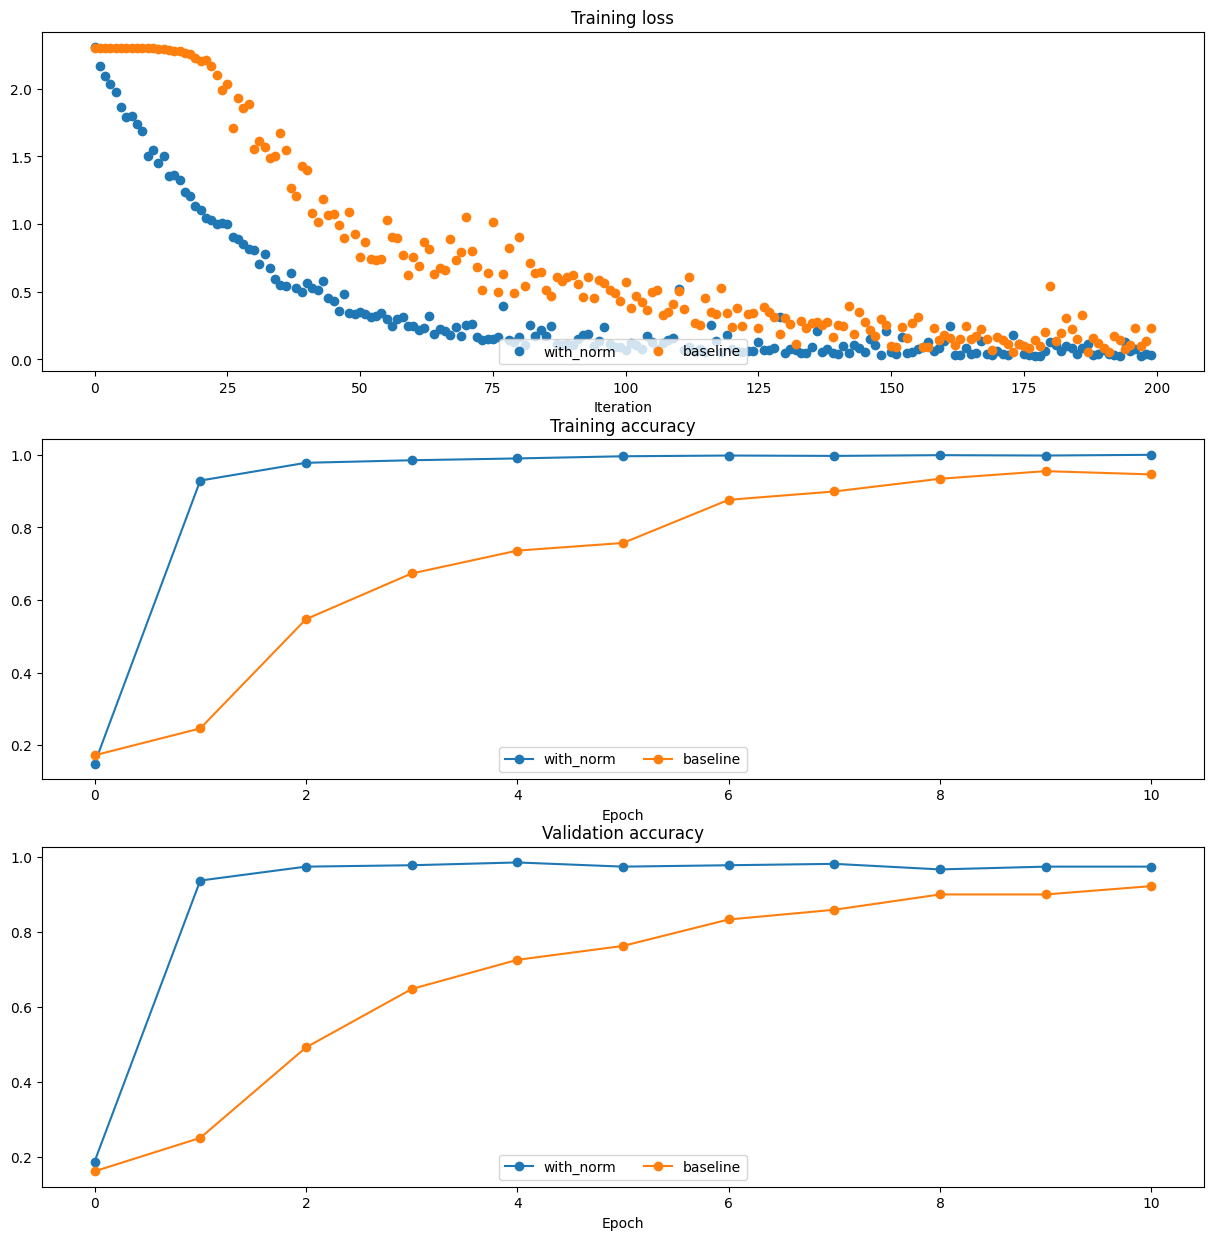

In [143]:
def plot_training_history(title, label, baseline, bn_solvers, plot_fn, bl_marker='.', bn_marker='.', labels=None):
    """utility function for plotting training history"""
    plt.title(title)
    plt.xlabel(label)
    bn_plots = [plot_fn(bn_solver) for bn_solver in bn_solvers]
    bl_plot = plot_fn(baseline)
    num_bn = len(bn_plots)
    for i in range(num_bn):
        label='with_norm'
        if labels is not None:
            label += str(labels[i])
        plt.plot(bn_plots[i], bn_marker, label=label)
    label='baseline'
    if labels is not None:
        label += str(labels[0])
    plt.plot(bl_plot, bl_marker, label=label)
    plt.legend(loc='lower center', ncol=num_bn+1) 

    
plt.subplot(3, 1, 1)
plot_training_history('Training loss','Iteration', solver, [bn_solver], \
                      lambda x: x.loss_history, bl_marker='o', bn_marker='o')
plt.subplot(3, 1, 2)
plot_training_history('Training accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.train_acc_history, bl_marker='-o', bn_marker='-o')
plt.subplot(3, 1, 3)
plot_training_history('Validation accuracy','Epoch', solver, [bn_solver], \
                      lambda x: x.val_acc_history, bl_marker='-o', bn_marker='-o')

plt.gcf().set_size_inches(15, 15)
plt.show()

#### Скорость сходимости увеличилась. Батч нормализация увеличивает скорость обучения

Обучите 6-тислойную сеть с батч-нормализацией и без нее, используя разные размеры батча. Визуализируйте графики обучения. Сделайте выводы по результатам эксперимента. 

In [144]:
def run_batchsize_experiments(normalization_mode):
    np.random.seed(231)
    # Try training a very deep net with batchnorm
    hidden_dims = [100, 100, 100, 100, 100]
    num_train = 1000
    small_data = {
      'X_train': data['X_train'][:num_train],
      'y_train': data['y_train'][:num_train],
      'X_val': data['X_val'],
      'y_val': data['y_val'],
    }
    n_epochs=10
    weight_scale = 2e-2
    batch_sizes = [5,10,50]
    lr = 10**(-3.5)
    solver_bsize = batch_sizes[0]

    print('No normalization: batch size = ',solver_bsize)
    model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=None)
    solver = Solver(model, small_data,
                    num_epochs=n_epochs, batch_size=solver_bsize,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False)
    solver.train()
    
    bn_solvers = []
    for i in range(len(batch_sizes)):
        b_size=batch_sizes[i]
        print('Normalization: batch size = ',b_size)
        bn_model = FullyConnectedNet(hidden_dims, weight_scale=weight_scale, normalization=normalization_mode)
        bn_solver = Solver(bn_model, small_data,
                        num_epochs=n_epochs, batch_size=b_size,
                        update_rule='adam',
                        optim_config={
                          'learning_rate': lr,
                        },
                        verbose=False)
        bn_solver.train()
        bn_solvers.append(bn_solver)
        
    return bn_solvers, solver, batch_sizes

batch_sizes = [5,10,50]
bn_solvers_bsize, solver_bsize, batch_sizes = run_batchsize_experiments('batchnorm')

No normalization: batch size =  5
Normalization: batch size =  5
Normalization: batch size =  10
Normalization: batch size =  50


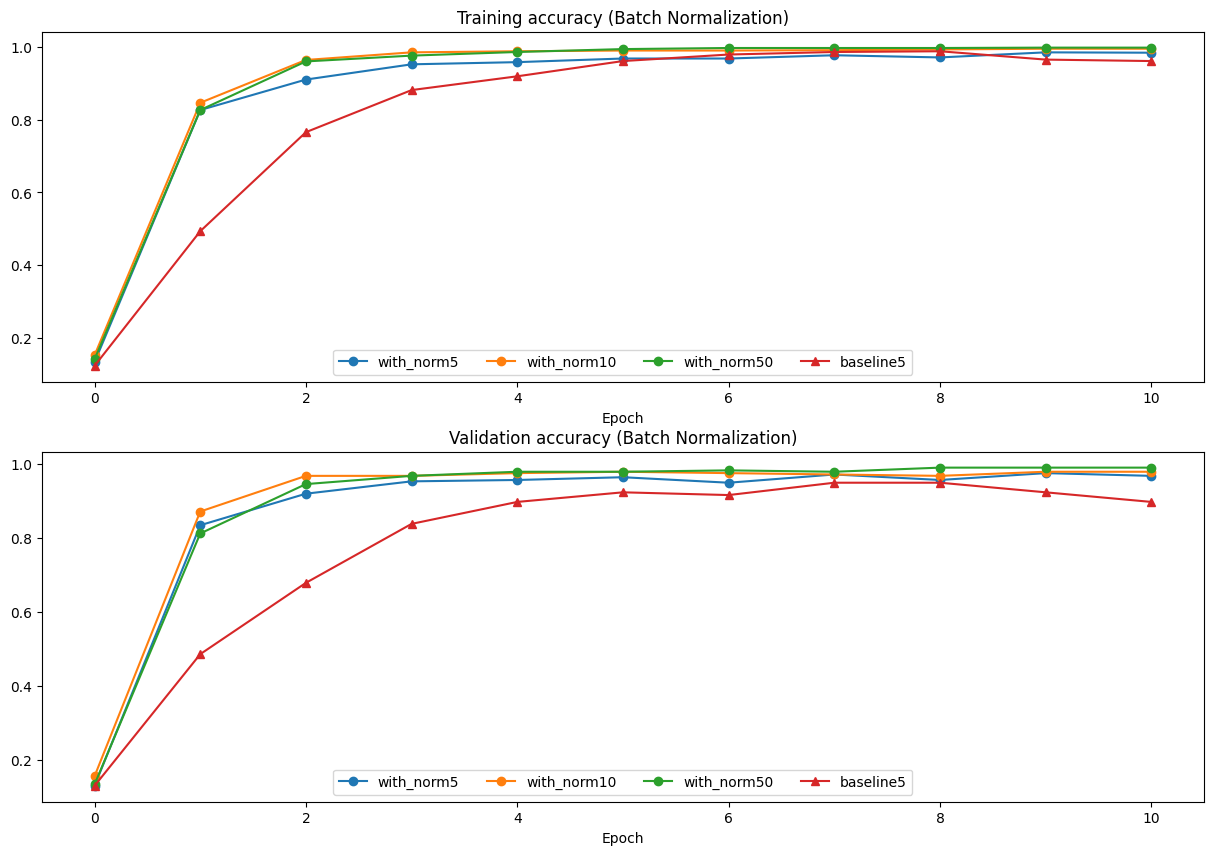

In [145]:
plt.subplot(2, 1, 1)
plot_training_history('Training accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.train_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)
plt.subplot(2, 1, 2)
plot_training_history('Validation accuracy (Batch Normalization)','Epoch', solver_bsize, bn_solvers_bsize, \
                      lambda x: x.val_acc_history, bl_marker='-^', bn_marker='-o', labels=batch_sizes)

plt.gcf().set_size_inches(15, 10)
plt.show()

#### С батч нормализацией лучше. По графикам видно, что чем больше батч был, тем лучше точность на валидации. 

#### Таким образом делая вывод про батч нормализацию: увеличивается скорость обучения, что для больших моделей позволит использовать меньше слоев и вследвствие быстрее их обучать

# Dropout

Реализуйте прямой проход для dropout-слоя в scripts/layers.py

http://cs231n.github.io/neural-networks-2/#reg

In [146]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
    out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
    out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

    print('Running tests with p = ', p)
    print('Mean of input: ', x.mean())
    print('Mean of train-time output: ', out.mean())
    print('Mean of test-time output: ', out_test.mean())
    print('Fraction of train-time output set to zero: ', (out == 0).mean())
    print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
    print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



Реализуйте обратный проход для dropout-слоя

In [147]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


Добавьте в реализацию класса FullyConnectedNet поддержку dropout. Если параметр dropout != 1, то добавьте в модель dropout-слой после каждого слоя активации. Проверьте свою реализацию

In [148]:
class FullyConnectedNet(object):
    """
    A fully-connected neural network with an arbitrary number of hidden layers,
    ReLU nonlinearities, and a softmax loss function. This will also implement
    dropout and batch/layer normalization as options. For a network with L layers,
    the architecture will be

    {affine - [batch/layer norm] - relu - [dropout]} x (L - 1) - affine - softmax

    where batch/layer normalization and dropout are optional, and the {...} block is
    repeated L - 1 times.

    Similar to the TwoLayerNet above, learnable parameters are stored in the
    self.params dictionary and will be learned using the Solver class.
    """

    def __init__(self, hidden_dims, input_dim=8*8, num_classes=10, 
                 dropout=1, normalization=None, reg=0.0, weight_scale=1e-2, dtype=np.float32, seed=None,):
        """
        Initialize a new FullyConnectedNet.

        Inputs:
        - hidden_dims: A list of integers giving the size of each hidden layer.
        - input_dim: An integer giving the size of the input.
        - num_classes: An integer giving the number of classes to classify.
        - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=1 then
          the network should not use dropout at all.
        - normalization: What type of normalization the network should use. Valid values
          are "batchnorm", "layernorm", or None for no normalization (the default).
        - reg: Scalar giving L2 regularization strength.
        - weight_scale: Scalar giving the standard deviation for random
          initialization of the weights.
        - dtype: A numpy datatype object; all computations will be performed using
          this datatype. float32 is faster but less accurate, so you should use
          float64 for numeric gradient checking.
        - seed: If not None, then pass this random seed to the dropout layers. This
          will make the dropout layers deteriminstic so we can gradient check the
          model.
        """
        self.normalization = normalization
        self.use_dropout = dropout != 1
        self.reg = reg
        self.num_layers = 1 + len(hidden_dims)
        self.dtype = dtype
        self.params = {}

        ############################################################################
        # TODO: Initialize the parameters of the network, storing all values in    #
        # the self.params dictionary. Store weights and biases for the first layer #
        # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
        # initialized from a normal distribution centered at 0 with standard       #
        # deviation equal to weight_scale. Biases should be initialized to zero.   #
        #                                                                          #
        # When using batch normalization, store scale and shift parameters for the #
        # first layer in gamma1 and beta1; for the second layer use gamma2 and     #
        # beta2, etc. Scale parameters should be initialized to ones and shift     #
        # parameters should be initialized to zeros.                               #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        D_H_C_dims = [input_dim] + hidden_dims + [num_classes]
        
        for idx in range(self.num_layers):
            nrows = D_H_C_dims[idx]
            ncols = D_H_C_dims[idx+1]

            layer_name = "%d" % (idx+1)
            weight_name = "W" + layer_name
            bias_name = "b" + layer_name
            self.params[weight_name] = weight_scale * np.random.randn(nrows, ncols)
            self.params[bias_name] = np.zeros(ncols)
            
            if self.normalization and idx < (self.num_layers - 1):
                self.params["gamma" + layer_name] = np.ones(ncols)
                self.params["beta" + layer_name] = np.zeros(ncols)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # When using dropout we need to pass a dropout_param dictionary to each
        # dropout layer so that the layer knows the dropout probability and the mode
        # (train / test). You can pass the same dropout_param to each dropout layer.
        self.dropout_param = {}
        if self.use_dropout:
            self.dropout_param = {"mode": "train", "p": dropout}
            if seed is not None:
                self.dropout_param["seed"] = seed

        # With batch normalization we need to keep track of running means and
        # variances, so we need to pass a special bn_param object to each batch
        # normalization layer. You should pass self.bn_params[0] to the forward pass
        # of the first batch normalization layer, self.bn_params[1] to the forward
        # pass of the second batch normalization layer, etc.
        self.bn_params = []
        if self.normalization == "batchnorm":
            self.bn_params = [{"mode": "train"} for i in range(self.num_layers - 1)]
        if self.normalization == "layernorm":
            self.bn_params = [{} for i in range(self.num_layers - 1)]

        # Cast all parameters to the correct datatype
        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Compute loss and gradient for the fully-connected net.

        Input / output: Same as TwoLayerNet above.
        """
        X = X.astype(self.dtype)
        mode = "test" if y is None else "train"

        # Set train/test mode for batchnorm params and dropout param since they
        # behave differently during training and testing.
        if self.use_dropout:
            self.dropout_param["mode"] = mode
        if self.normalization == "batchnorm":
            for bn_param in self.bn_params:
                bn_param["mode"] = mode
        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the fully-connected net, computing  #
        # the class scores for X and storing them in the scores variable.          #
        #                                                                          #
        # When using dropout, you'll need to pass self.dropout_param to each       #
        # dropout forward pass.                                                    #
        #                                                                          #
        # When using batch normalization, you'll need to pass self.bn_params[0] to #
        # the forward pass for the first batch normalization layer, pass           #
        # self.bn_params[1] to the forward pass for the second batch normalization #
        # layer, etc.                                                              #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        caches = {}
        scores = X
    
        for i in range(1, self.num_layers + 1):
            layer_name = "%d" % i
            W_name = "W" + layer_name
            b_name = "b" + layer_name
            cache_name = "cache" + layer_name
            
            gamma_name = "gamma" + layer_name
            beta_name = "beta" + layer_name
            
            dropout_name = "dropout" + layer_name
      
            if self.num_layers == i:
                scores, cache = affine_forward(scores, self.params[W_name], self.params[b_name])
                
            else:
                if self.normalization:
                    scores, cache = affine_batchnorm_relu_forward(
                        scores, self.params[W_name], self.params[b_name],self.params[gamma_name], 
                        self.params[beta_name], self.bn_params[i-1])
                else:
                    scores, cache = affine_relu_forward(scores, self.params[W_name], self.params[b_name])
                    
                if self.use_dropout:
                    scores, caches[dropout_name] = dropout_forward(scores, self.dropout_param)
  
            caches[cache_name] = cache

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        # If test mode return early
        if mode == "test":
            return scores

        loss, grads = 0.0, {}
        ############################################################################
        # TODO: Implement the backward pass for the fully-connected net. Store the #
        # loss in the loss variable and gradients in the grads dictionary. Compute #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # When using batch/layer normalization, you don't need to regularize the scale   #
        # and shift parameters.                                                    #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        grads = {}
        loss, dx = softmax_loss(scores, y)

        for i in range(self.num_layers, 0, -1):
            layer_name = "%d" % i
            W_name = "W" + layer_name
            b_name = "b" + layer_name
            cache_name = "cache" + layer_name
            
            gamma_name = "gamma" + layer_name
            beta_name = "beta" + layer_name
            
            dropout_name = "dropout" + layer_name
      
            loss += 0.5 * self.reg * (self.params[W_name] ** 2).sum()
      
            if self.num_layers == i:
                dx, grads[W_name], grads[b_name] = affine_backward(dx, caches[cache_name])
            
            else:
                if self.use_dropout:
                    dx = dropout_backward(dx, caches[dropout_name])
        
                if self.normalization:
                    (dx, grads[W_name], grads[b_name], grads[gamma_name],grads[beta_name]) = affine_batchnorm_relu_backward(
                        dx, caches[cache_name])
                else:
                    (dx, grads[W_name], grads[b_name]) = affine_relu_backward(dx, caches[cache_name])

            grads[W_name] += self.reg * self.params[W_name]


        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

#### Cнова чуток добавили, лень пояснять...

In [149]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
    print('Running check with dropout = ', dropout)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C, weight_scale=5e-2, 
                              dtype=np.float64, dropout=dropout, seed=123)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
  
    # Relative errors should be around e-6 or less; Note that it's fine
    # if for dropout=1 you have W2 error be on the order of e-5.
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
    print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



Обучите две двухслойные сети с dropout-слоем (вероятность отсева 0,25) и без на наборе из 500 изображений. Визуализируйте графики обучения. Сделайте выводы по результатам эксперимента

In [150]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.75]
for dropout in dropout_choices:
    model = FullyConnectedNet([500], dropout=dropout)
    print(dropout)

    solver = Solver(model, small_data, num_epochs=25, batch_size=100, update_rule='adam',
                    optim_config={'learning_rate': 5e-4,}, verbose=True, print_every=100)
    solver.train()
    solvers[dropout] = solver
    print()
    y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
    y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
    print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
    print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())
    print()

1
(Iteration 1 / 125) loss: 2.317956
(Epoch 0 / 25) train acc: 0.470000; val_acc: 0.437037
(Epoch 1 / 25) train acc: 0.778000; val_acc: 0.796296
(Epoch 2 / 25) train acc: 0.840000; val_acc: 0.862963
(Epoch 3 / 25) train acc: 0.852000; val_acc: 0.888889
(Epoch 4 / 25) train acc: 0.860000; val_acc: 0.896296
(Epoch 5 / 25) train acc: 0.894000; val_acc: 0.903704
(Epoch 6 / 25) train acc: 0.910000; val_acc: 0.911111
(Epoch 7 / 25) train acc: 0.928000; val_acc: 0.944444
(Epoch 8 / 25) train acc: 0.948000; val_acc: 0.944444
(Epoch 9 / 25) train acc: 0.958000; val_acc: 0.944444
(Epoch 10 / 25) train acc: 0.972000; val_acc: 0.940741
(Epoch 11 / 25) train acc: 0.976000; val_acc: 0.944444
(Epoch 12 / 25) train acc: 0.980000; val_acc: 0.951852
(Epoch 13 / 25) train acc: 0.982000; val_acc: 0.951852
(Epoch 14 / 25) train acc: 0.986000; val_acc: 0.951852
(Epoch 15 / 25) train acc: 0.990000; val_acc: 0.955556
(Epoch 16 / 25) train acc: 0.990000; val_acc: 0.955556
(Epoch 17 / 25) train acc: 0.994000; v

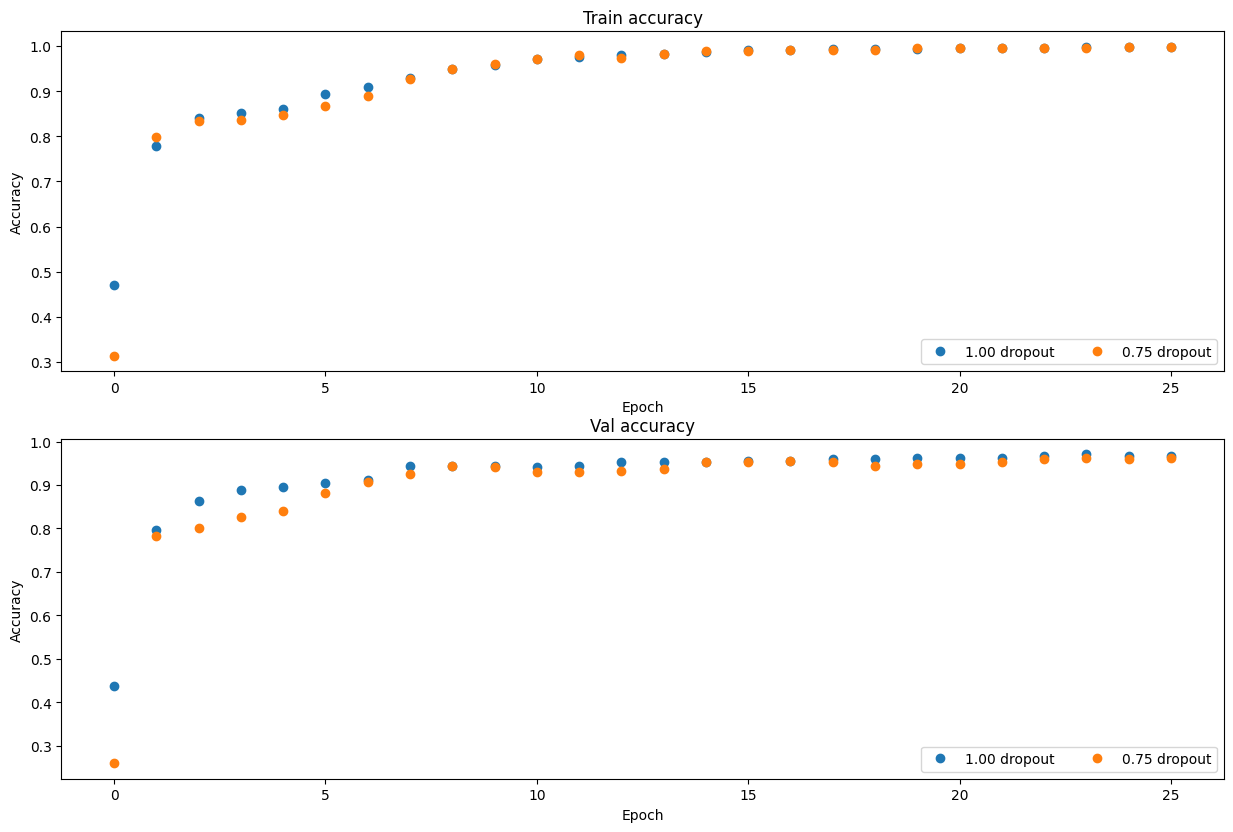

In [151]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
    solver = solvers[dropout]
    train_accs.append(solver.train_acc_history[-1])
    val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
    plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

#### эксперимент показал что при использовании dropout результаты выходят хуже и на валидации и на трейне. Вместо этого результат на тестовых данных при использовании dropout почти не отличается от результата на валидационных.

#### Сказать по текущему эксмперименту, что обучение идет быстрее или это помогает избежать переобучения нелья

# Сверточные нейронные сети (CNN)

Реализуйте прямой проход для сверточного слоя - функция conv_forward_naive в scripts/layers.py Проверьте свою реализацию, запустив код ниже 

In [152]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)

correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


#### Нормальная ошибка

Реализуйте обратный проход - функция conv_backward_naive в scripts/layers.py

In [153]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around e-8 or less.
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  2.9516731319807213e-09
dw error:  5.185597891706744e-10
db error:  2.1494967362289156e-11


Реализуйте прямой проход для max-pooling слоя -функция  max_pool_forward_naive в scripts/layers.py

In [154]:
x_shape = (2, 3, 4, 4)
x = np.linspace(-0.3, 0.4, num=np.prod(x_shape)).reshape(x_shape)
pool_param = {'pool_width': 2, 'pool_height': 2, 'stride': 2}

out, _ = max_pool_forward_naive(x, pool_param)

correct_out = np.array([[[[-0.26315789, -0.24842105],
                          [-0.20421053, -0.18947368]],
                         [[-0.14526316, -0.13052632],
                          [-0.08631579, -0.07157895]],
                         [[-0.02736842, -0.01263158],
                          [ 0.03157895,  0.04631579]]],
                        [[[ 0.09052632,  0.10526316],
                          [ 0.14947368,  0.16421053]],
                         [[ 0.20842105,  0.22315789],
                          [ 0.26736842,  0.28210526]],
                         [[ 0.32631579,  0.34105263],
                          [ 0.38526316,  0.4       ]]]])

# Compare your output with ours. Difference should be on the order of e-8.
print('Testing max_pool_forward_naive function:')
print('difference: ', rel_error(out, correct_out))

Testing max_pool_forward_naive function:
difference:  4.1666665157267834e-08


#### Снова нормальная ошибка

Реализуйте обратный проход для max-pooling слоя в max_pool_backward_naive . 

In [155]:
np.random.seed(231)
x = np.random.randn(3, 2, 8, 8)
dout = np.random.randn(3, 2, 4, 4)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

dx_num = eval_numerical_gradient_array(lambda x: max_pool_forward_naive(x, pool_param)[0], x, dout)

out, cache = max_pool_forward_naive(x, pool_param)
dx = max_pool_backward_naive(dout, cache)

# Your error should be on the order of e-12
print('Testing max_pool_backward_naive function:')
print('dx error: ', rel_error(dx, dx_num))

Testing max_pool_backward_naive function:
dx error:  3.27562514223145e-12


В скрипте scripts/fast_layers.py представлены быстрые реализации слоев свертки и пуллинга, написанных с использованием  Cython. 

Для компиляции выполните следующую команду в директории scripts

```bash
python setup.py build_ext --inplace
```

Сравните ваши реализации слоев свертки и пуллинга с быстрыми реализациями.

In [156]:
# !pip install Cython

%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [157]:
!python setup.py build_ext --inplace

In [158]:
# Rel errors should be around e-9 or less
from fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 1.621053s
Fast: 0.005999s
Speedup: 270.205898x
Difference:  3.94112628138944e-11

Testing conv_backward_fast:
Naive: 4.912267s
Fast: 0.007000s
Speedup: 701.755552x
dx difference:  8.875097157270652e-12
dw difference:  5.155328198574655e-13
db difference:  0.0


In [159]:
# Relative errors should be close to 0.0
from fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.169008s
fast: 0.004000s
speedup: 42.252548x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.816624s
fast: 0.008000s
speedup: 102.082407x
dx difference:  0.0


### Сравнили, вроде, все хорошо получилось, однако наши реализации существенно медленнее

В layer_utils.py вы можете найти  часто используемые комбинации слоев, используемых в сверточных сетях. Ознакомьтесь с ними и запустите код ниже для проверки их работы

In [160]:
from layer_utils import conv_relu_pool_forward, conv_relu_pool_backward
np.random.seed(231)
x = np.random.randn(2, 3, 16, 16)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

out, cache = conv_relu_pool_forward(x, w, b, conv_param, pool_param)
dx, dw, db = conv_relu_pool_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_pool_forward(x, w, b, conv_param, pool_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu_pool')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu_pool
dx error:  9.591132621921372e-09
dw error:  5.802401370096438e-09
db error:  1.0146343411762047e-09


In [161]:
from layer_utils import conv_relu_forward, conv_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 8, 8)
w = np.random.randn(3, 3, 3, 3)
b = np.random.randn(3,)
dout = np.random.randn(2, 3, 8, 8)
conv_param = {'stride': 1, 'pad': 1}

out, cache = conv_relu_forward(x, w, b, conv_param)
dx, dw, db = conv_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: conv_relu_forward(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_relu_forward(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_relu_forward(x, w, b, conv_param)[0], b, dout)

# Relative errors should be around e-8 or less
print('Testing conv_relu:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing conv_relu:
dx error:  1.5218619980349303e-09
dw error:  2.702022646099404e-10
db error:  1.451272393591721e-10


Напишите реализацию класса ThreeLayerConvNet в scripts/classifiers/cnn.py . Вы можете использовать готовые реализации слоев и их комбинаций.

In [162]:
class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:

    conv - relu - 2x2 max pool - affine - relu - affine - softmax

    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(1,8,8), num_filters=32, filter_size=7, hidden_dim=100,
                 num_classes=10, weight_scale=1e-3, reg=0.0, dtype=np.float32,):
        """
        Initialize a new network.

        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer
        - filter_size: Width/height of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - num_classes: Number of scores to produce from the final affine layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.reg = reg
        self.dtype = dtype

        ############################################################################
        # TODO: Initialize weights and biases for the three-layer convolutional    #
        # network. Weights should be initialized from a Gaussian centered at 0.0   #
        # with standard deviation equal to weight_scale; biases should be          #
        # initialized to zero. All weights and biases should be stored in the      #
        #  dictionary self.params. Store weights and biases for the convolutional  #
        # layer using the keys 'W1' and 'b1'; use keys 'W2' and 'b2' for the       #
        # weights and biases of the hidden affine layer, and keys 'W3' and 'b3'    #
        # for the weights and biases of the output affine layer.                   #
        #                                                                          #
        # IMPORTANT: For this assignment, you can assume that the padding          #
        # and stride of the first convolutional layer are chosen so that           #
        # **the width and height of the input are preserved**. Take a look at      #
        # the start of the loss() function to see how that happens.                #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        C, H, W = input_dim
        self.params['W1'] = weight_scale * np.random.randn(num_filters, C, filter_size, filter_size)
        self.params['b1'] = np.zeros([num_filters])
        
        self.params['W2'] = weight_scale * np.random.randn(num_filters * H//2 * W//2, hidden_dim)
        self.params['b2'] = np.zeros([hidden_dim])

        self.params['W3'] = weight_scale * np.random.randn(hidden_dim, num_classes)
        self.params['b3'] = np.zeros([num_classes])

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)

    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.

        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        W1, b1 = self.params["W1"], self.params["b1"]
        W2, b2 = self.params["W2"], self.params["b2"]
        W3, b3 = self.params["W3"], self.params["b3"]

        # pass conv_param to the forward pass for the convolutional layer
        # Padding and stride chosen to preserve the input spatial size
        filter_size = W1.shape[2]
        conv_param = {"stride": 1, "pad": (filter_size - 1) // 2}

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {"pool_height": 2, "pool_width": 2, "stride": 2}

        scores = None
        ############################################################################
        # TODO: Implement the forward pass for the three-layer convolutional net,  #
        # computing the class scores for X and storing them in the scores          #
        # variable.                                                                #
        #                                                                          #
        # Remember you can use the functions defined in cs231n/fast_layers.py and  #
        # cs231n/layer_utils.py in your implementation (already imported).         #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        caches = {}

        (scores, caches['conv']) = conv_relu_pool_forward(X, W1, b1, conv_param, pool_param)
        (scores, caches['hidden']) = affine_relu_forward(scores, W2, b2)
        (scores, caches['final']) = affine_forward(scores, W3, b3)

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        if y is None:
            return scores

        loss, grads = 0, {}
        ############################################################################
        # TODO: Implement the backward pass for the three-layer convolutional net, #
        # storing the loss and gradients in the loss and grads variables. Compute  #
        # data loss using softmax, and make sure that grads[k] holds the gradients #
        # for self.params[k]. Don't forget to add L2 regularization!               #
        #                                                                          #
        # NOTE: To ensure that your implementation matches ours and you pass the   #
        # automated tests, make sure that your L2 regularization includes a factor #
        # of 0.5 to simplify the expression for the gradient.                      #
        ############################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        loss, dx = softmax_loss(scores, y)

        dx, grads['W3'], grads['b3'] = affine_backward(dx, caches['final'])
        dx, grads['W2'], grads['b2'] = affine_relu_backward(dx, caches['hidden'])
        dx, grads['W1'], grads['b1'] = conv_relu_pool_backward(dx, caches['conv'])

        for w_name in ['W1', 'W2', 'W3']:
            loss += 0.5 * self.reg * (self.params[w_name] ** 2).sum()

            grads[w_name] += self.reg * self.params[w_name]

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        #                             END OF YOUR CODE                             #
        ############################################################################

        return loss, grads

Проверьте вашу реализацию. Ожидается, что значение функции потерь softmax будет порядка `log(C)` для `C` классов для случая без регуляризации. В случае регуляризации значение функции потерь должно немного возрасти. 

In [163]:
model = ThreeLayerConvNet(input_dim=(3,32,32), num_filters=32, filter_size=7)

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.302586071243987
Initial loss (with regularization):  2.508255635671795


#### Получилось, как и ожидали

Проверьте реализацию обратного прохода

In [164]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
# Errors should be small, but correct implementations may have
# relative errors up to the order of e-2
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


Попробуйте добиться эффекта переобучения. Обучите модель на небольшом наборе данных.Сравните значения accuracy на обучающих данных и на валидационных. Визуализируйте графики обучения 

In [165]:
data['X_train'] = data['X_train'].reshape([-1,1,8,8])
data['X_val'] = data['X_val'].reshape([-1,1,8,8])
data['X_test'] = data['X_test'].reshape([-1,1,8,8])
np.random.seed(231)

num_train = 100
small_data = {
    'X_train': data['X_train'][:num_train],
    'y_train': data['y_train'][:num_train],
    'X_val': data['X_val'],
    'y_val': data['y_val'],
    'X_test': data['X_test'][:num_train],
    'y_test': data['X_test'][:num_train],
    
    
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-2,
                },
                verbose=True, print_every=1)
solver.train()

(Iteration 1 / 30) loss: 2.303189
(Epoch 0 / 15) train acc: 0.290000; val_acc: 0.251852
(Iteration 2 / 30) loss: 2.240123
(Epoch 1 / 15) train acc: 0.210000; val_acc: 0.144444
(Iteration 3 / 30) loss: 2.153891
(Iteration 4 / 30) loss: 1.737921
(Epoch 2 / 15) train acc: 0.340000; val_acc: 0.322222
(Iteration 5 / 30) loss: 1.591481
(Iteration 6 / 30) loss: 1.282350
(Epoch 3 / 15) train acc: 0.690000; val_acc: 0.633333
(Iteration 7 / 30) loss: 1.075656
(Iteration 8 / 30) loss: 0.928530
(Epoch 4 / 15) train acc: 0.800000; val_acc: 0.759259
(Iteration 9 / 30) loss: 0.534797
(Iteration 10 / 30) loss: 0.698532
(Epoch 5 / 15) train acc: 0.880000; val_acc: 0.770370
(Iteration 11 / 30) loss: 0.395800
(Iteration 12 / 30) loss: 0.290184
(Epoch 6 / 15) train acc: 0.810000; val_acc: 0.703704
(Iteration 13 / 30) loss: 0.576668
(Iteration 14 / 30) loss: 0.923759
(Epoch 7 / 15) train acc: 0.940000; val_acc: 0.829630
(Iteration 15 / 30) loss: 0.137962
(Iteration 16 / 30) loss: 0.193480
(Epoch 8 / 15) tr

In [166]:
# Print final training accuracy
print(
    "Small data training accuracy:",
    solver.check_accuracy(small_data['X_train'], small_data['y_train'])
)

Small data training accuracy: 0.95


In [167]:
# Print final validation accuracy
print(
    "Small data validation accuracy:",
    solver.check_accuracy(small_data['X_val'], small_data['y_val'])
)

Small data validation accuracy: 0.8592592592592593


In [168]:
# Print final test accuracy
print(
    "Small data test accuracy:",
    solver.check_accuracy(small_data['X_test'], small_data['y_test'])
)

Small data test accuracy: 0.0


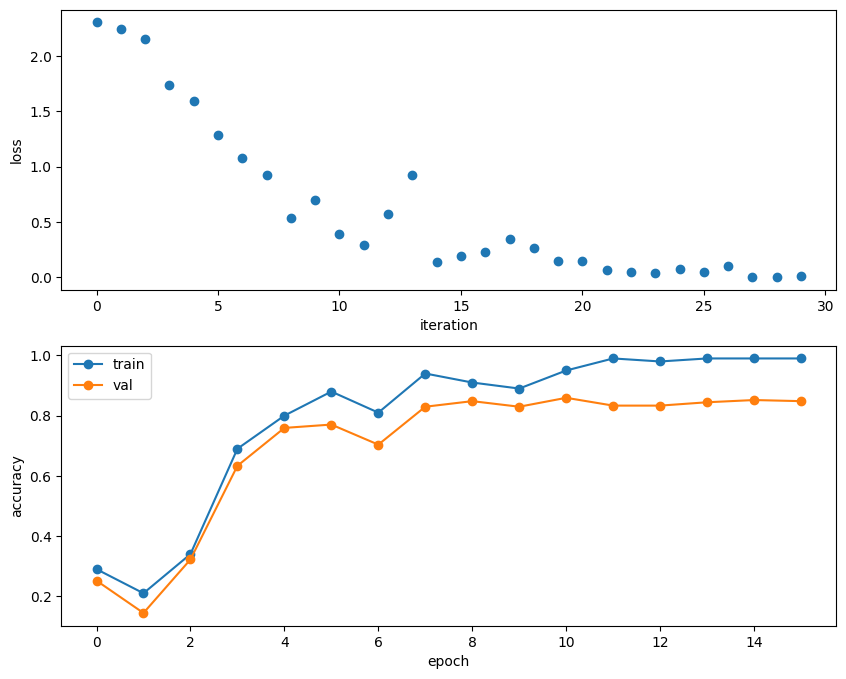

In [169]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#### Получили явное переобучение, что тут еще сказать...

Обучите сеть на полном наборе данных. Выведите accuracy на обучающей и валидационной выборках

In [170]:
model = ThreeLayerConvNet(weight_scale=0.001, hidden_dim=500, reg=0.001)

solver = Solver(model, data,
                num_epochs=1, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=5)
solver.train()

(Iteration 1 / 25) loss: 2.302716
(Epoch 0 / 1) train acc: 0.208000; val_acc: 0.211111
(Iteration 6 / 25) loss: 2.275179
(Iteration 11 / 25) loss: 2.059934
(Iteration 16 / 25) loss: 1.683075
(Iteration 21 / 25) loss: 1.315682
(Epoch 1 / 1) train acc: 0.748000; val_acc: 0.774074


In [171]:
# Print final training accuracy
print(
    "Full data training accuracy:",
    solver.check_accuracy(data['X_train'], data['y_train'])
)

Full data training accuracy: 0.7382657120127287


In [172]:
# Print final validation accuracy
print(
    "Full data validation accuracy:",
    solver.check_accuracy(data['X_val'], data['y_val'])
)

Full data validation accuracy: 0.774074074074074


In [173]:
# Print final test accuracy
print(
    "Full data test accuracy:",
    solver.check_accuracy(data['X_test'], data['y_test'])
)

Full data test accuracy: 0.7555555555555555


## Получили более или менее адекватные результаты на полном наборе

Визуализируйте фильтры на первом слое обученной сети

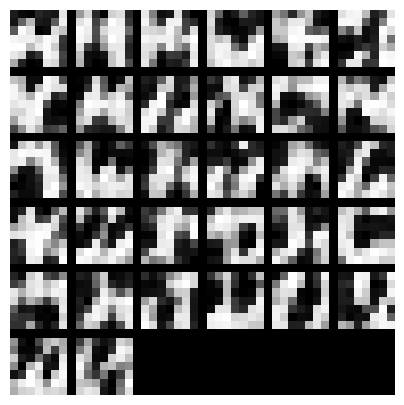

In [174]:
from vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

#### Вуаля